# 1. Data input

### 1.1 Read the metadata table (clusters_df): strain name and paths of their mortality data .pickles

In [1]:
import os, pandas
%cd '/app/src/ms2_post_analysis'
from math import isnan
csv_df = pandas.read_csv('Github Links MS2 - Sheet1.csv',sep=',')
#clusters_df = csv_df.drop([0])
clusters_df = csv_df
clusters_df = clusters_df.iloc[:,:]
clusters_df.columns = ['genotype','url','cluster', 'Obs','Unnamed','Unnamed']
clusters_df = clusters_df[clusters_df['url']!='in progress']
clusters_df = clusters_df[clusters_df['url'].isnull()==False]

to_drop = []
import urlparse, urllib
from os import path
for i in range(len(clusters_df)):
    url_parsed = urlparse.urlparse(clusters_df.iloc[i]['url'])
    relative_path = urllib.unquote('/'.join(url_parsed.path.split('/')[5:])).decode('utf8')
    clusters_df.loc[clusters_df.index[i], 'path'] = relative_path
    strain_name = url_parsed.path.split('/')[-1]
    if isnan(clusters_df.loc[clusters_df.index[i], 'cluster']):
        print "not fit GG or GGM",strain_name
        to_drop.append(i)
        continue
    clusters_df.loc[clusters_df.index[i], 'strain'] = strain_name
    clusters_df.loc[clusters_df.index[i], 'cluster'] = str(int(clusters_df.loc[clusters_df.index[i], 'cluster']))

clusters_df = clusters_df.drop(to_drop)

/app/src/ms2_post_analysis
not fit GG or GGM alr
not fit GG or GGM atoS
not fit GG or GGM hybG


### 1.2 Locate mortality clusters

In [ ]:
%cd '/app/src/ms2'

In [ ]:
import re
to_drop = []
for ind in clusters_df.index:
    #print clusters_df.loc[ind]['path']
    try:
        re_mortality1 = re.compile('(.*) mortality_dataframe_cluster(\d).pickle')
        re_mortality2 = re.compile('(.*)_mortality_dataframe_cluster(\d).pickle')
        re_mortality = re.compile('(.*?.)mortality_dataframe_cluster(\d).pickle')
        matches1 = [fn for fn in os.listdir(clusters_df.loc[ind,'path']) if re.match(re_mortality1, fn)]
        matches2 = [fn for fn in os.listdir(clusters_df.loc[ind,'path']) if re.match(re_mortality2, fn)]
        matches = (matches1, matches2)[len(matches1) == 0]
        if len(set([re.match(re_mortality, fn).groups()[0] for fn in matches]))>1:
                raise Exception(matches)
        if len(matches) < int(clusters_df.loc[ind,'cluster']):
            raise Exception(matches.__str__)
        basename = re.match(re_mortality, matches[0]).groups()[0]
        clusters_df.loc[ind, 'basename'] = basename
    except:
        to_drop.append(ind)
print to_drop
clusters_df = clusters_df.drop(to_drop)        


In [ ]:
from os import path
for ind in clusters_df.index:
    re_mortality = re.compile(clusters_df.loc[ind, 'basename']+'mortality_dataframe_cluster'+'\d'+'.pickle')
    matches = [fn for fn in os.listdir(clusters_df.loc[ind,'path']) if re.match(re_mortality, fn)]
    if len(matches)-1 < int(clusters_df.loc[ind,'cluster']):
        print 'Droped: ',clusters_df.loc[ind,'path'], matches, clusters_df.loc[ind,'cluster']
        clusters_df.drop(ind,inplace=True)
        

### 1.4 Drop data known to not fit GGM

### 1.5 Load mortality .pickles (pip install pandas==0.19.2)

In [ ]:
import pickle
import numpy as np
import pandas as pd
#from Df_timegrid import Df_timegrid
dfs_mortality = dict()
tgs_mortality = dict()
for ind in clusters_df.index:
    fn_mortality = path.join(clusters_df.loc[ind,'path'], clusters_df.loc[ind,'basename']+'mortality_dataframe_cluster'+clusters_df.loc[ind,'cluster']+'.pickle' )
    fn_timegrid = path.join(clusters_df.loc[ind,'path'], clusters_df.loc[ind,'basename']+'relative_timegrid_cluster'+clusters_df.loc[ind,'cluster']+'.pickle' )
    dfs_mortality[clusters_df.loc[ind,'strain']] = pickle.load( open(fn_mortality, 'rb') )
    tg = pickle.load( open(fn_timegrid, 'rb') )
    tgs_mortality[clusters_df.loc[ind,'strain']] = np.array(pd.Series(tg)[tg<=np.max(dfs_mortality[clusters_df.loc[ind,'strain']]['mortality'])])

# 2. Redo statistical mortality analysis and quality control

### 2.1 Fit to GG or GGM

In [ ]:
%cd '/app/src/ms2_post_analysis'
from cohortMortalitySummary import GGMfit, GGfit
GGM_fitted = dict()
GG_fitted = dict()
Fitted = dict()
for ind in clusters_df.index:
    GGM_fitted[clusters_df.loc[ind,'strain']] = GGMfit(dfs_mortality[clusters_df.loc[ind,'strain']])
    try:
        GG_fitted[clusters_df.loc[ind,'strain']] = GGfit(dfs_mortality[clusters_df.loc[ind,'strain']])
        if GG_fitted[clusters_df.loc[ind,'strain']]['AIC'] < GGM_fitted[clusters_df.loc[ind,'strain']]['AIC']:
            Fitted[clusters_df.loc[ind,'strain']] = GG_fitted[clusters_df.loc[ind,'strain']]
            Fitted[clusters_df.loc[ind,'strain']]['type'] = 'GG'
            print clusters_df.loc[ind,'strain'] + ': GG'
        else:
            Fitted[clusters_df.loc[ind,'strain']] = GGM_fitted[clusters_df.loc[ind,'strain']]
            Fitted[clusters_df.loc[ind,'strain']]['type'] = 'GGM'
            print clusters_df.loc[ind,'strain'] + ': GGM'
    except:
        Fitted[clusters_df.loc[ind,'strain']] = GGM_fitted[clusters_df.loc[ind,'strain']]
        Fitted[clusters_df.loc[ind,'strain']]['type'] = 'GGM'
        print clusters_df.loc[ind,'strain'] + ': GGM'

In [ ]:
import dill
dill_file = open("dill/Fitted.p", "wb")
dill_file.write(dill.dumps(Fitted))
dill_file.close()

import dill
dill_file = open("dill/dfs_mortality.p", "wb")
dill_file.write(dill.dumps(dfs_mortality))
dill_file.close()

import dill
dill_file = open("dill/tgs_mortality.p", "wb")
dill_file.write(dill.dumps(tgs_mortality))
dill_file.close()

import dill
dill_file = open("dill/quantiles.p", "wb")
dill_file.write(dill.dumps(quantiles))
dill_file.close()

import dill
dill_file = open("dill/KStests.p", "wb")
dill_file.write(dill.dumps(KStests))
dill_file.close()

import dill
dill_file = open("dill/stats.p", "wb")
dill_file.write(dill.dumps(stats))
dill_file.close()

In [ ]:
%pwd

### 2.2 Generate bootstrapped statistics: Medians, GGM parameters

In [4]:
#%cd '/app/src/ms2_post_analysis'
from cohortMortalitySummary import rflexsurv, globalenv, ro, pandas2ri
import numpy as np
import os
flexsurvreg = rflexsurv.flexsurvreg
normboot = rflexsurv.normboot_flexsurvreg
ro.r.source(os.path.join( 'Rmodels', 'GammaGompertz.R'), echo=False,verbose=False);
ro.r.source(os.path.join( 'Rmodels', 'GammaGompertzMakeham.R'), echo=False,verbose=False);
qgammagompertz = globalenv['qgammagompertz']
pgammagompertzmakeham = globalenv['pgammagompertzmakeham']
def gg_med(para):
    return np.array(qgammagompertz(0.5,
                        para['beta'],
                        para['s'],
                        para['rate']))[0]

def ggm_med(para, precision=0.1, max_t = 150):
    ptime = np.arange(0,max_t,precision)
    rtime = ro.Vector(ptime)
    probs = np.array(pgammagompertzmakeham(rtime,para['rate'],
                                            para['beta'],
                                            para['s'],
                                            para['lambda']))
    while probs[-1]<0.5:
        ptime = np.arange(max_t, max_t+100, precision)
        rtime = ro.Vector(ptime)
        probs = np.array(pgammagompertzmakeham(rtime,para['rate'],
                                            para['beta'],
                                            para['s'],
                                            para['lambda']))
        max_t += 100
    return ptime[probs>=0.5][0]
    

In [ ]:
import pandas as pd
stats = dict()
strain_error = []
for strain in Fitted.keys():
    print strain
    try:
        paras = pandas2ri.ri2py(normboot(Fitted[strain]['flexsurvreg'],B=50000))
        if Fitted[strain]['type'] == 'GGM':
            stats[strain]=pd.DataFrame(data=paras,columns=['rate','beta','s','lambda'])
        elif Fitted[strain]['type'] == 'GG':
            stats[strain]=pd.DataFrame(data=paras,columns=['beta','s','rate'])
            stats[strain]['lambda'] = pd.Series([0]*len(paras))
        meds = [(ggm_med(dict(stats[strain].iloc[i,:])), gg_med(dict(stats[strain].iloc[i,:])))[Fitted[strain]['type'] == 'GG'] for i in range(len(paras))]
        stats[strain]['median'] = pd.Series(data=meds)
    except:
        #paras = pandas2ri.ri2py(normboot(Fitted[strain]['flexsurvreg'],B=50000))
        print "error ", strain
        strain_error.append(strain)
        
        
        

In [7]:
pd.DataFrame(data=paras,columns=['rate','beta','s','lambda'])

NameError: name 'paras' is not defined

In [8]:
strain_error

NameError: name 'strain_error' is not defined

### 2.3 Goodness-of-fit by K-S statistics & quality control

In [ ]:
from cohortMortalitySummary import KSm_gof, KSm_test
KStests = dict()
for strain in Fitted.keys():
    if strain in strain_error:
        print "jump ", strain
        continue
    data = dfs_mortality[strain]
    rtg = tgs_mortality[strain]
    sf = Fitted[strain]['ML_survivorship']
    residues = KSm_gof(data, rtg, sf)
    KStests[strain] = KSm_test(residues[0], residues[1], alpha=0.01)

### These data cross K-S thresholds, but only in very few time points, thus pass quality control

In [ ]:
for strain in Fitted.keys():
    if strain in strain_error:
        print "jump ", strain
        continue
    if KStests[strain][0] > 1.517:
        print strain, KStests[strain]

### Mortality cluster with too few imaging positions, dropped later

In [ ]:
for strain in dfs_mortality.keys():
    if strain in strain_error:
        print "jump ", strain
        continue
    if len(np.unique(dfs_mortality[strain]['fn'])) < 3:
        print strain

### 2.4 Important Quantiles

In [ ]:
def gg_q(q, para):
    return np.array(qgammagompertz(q,
                        para['beta'],
                        para['s'],
                        para['rate']))[0]

def ggm_q(q, para, precision=0.1, max_t = 150):
    ptime = np.arange(0,max_t,precision)
    rtime = ro.Vector(ptime)
    probs = np.array(pgammagompertzmakeham(rtime,para['rate'],
                                            para['beta'],
                                            para['s'],
                                            para['lambda']))
    while probs[-1]<q:
        ptime = np.arange(max_t, max_t+100, precision)
        rtime = ro.Vector(ptime)
        probs = np.array(pgammagompertzmakeham(rtime,para['rate'],
                                            para['beta'],
                                            para['s'],
                                            para['lambda']))
        max_t += 100
    return ptime[probs>=q][0]
quantiles = dict()
for strain in Fitted.keys():
    if strain in strain_error:
        print "jump ", strain
        continue
    print strain+': '+Fitted[strain]['type']
    paras = pandas2ri.ri2py(normboot(Fitted[strain]['flexsurvreg'],B=5000))
    if Fitted[strain]['type'] == 'GGM':
        quantiles[strain]=pd.DataFrame(data=paras,columns=['rate','beta','s','lambda'])
    elif Fitted[strain]['type'] == 'GG':
        quantiles[strain]=pd.DataFrame(data=paras,columns=['beta','s','rate'])
        quantiles[strain]['lambda'] = pd.Series([0]*len(paras))
    for q in [0.1,0.25,0.5,0.75,0.9]:
        #print q
        qs = [(ggm_q(q, dict(quantiles[strain].iloc[i,:])), gg_q(q,dict(quantiles[strain].iloc[i,:])))[Fitted[strain]['type'] == 'GG'] for i in range(len(paras))]
        quantiles[strain]['q='+str(q)] = pd.Series(data=qs, index=quantiles[strain].index)

# 3. Aging parameters basics: first figures

### 3.1 Set basic info for plotting: strain aging parameters dataframe (strain_df) and strain categories

In [10]:
import dill
dill_file = open("dill/Fitted.p", "rb")
Fitted_from_file = dill.load(dill_file)
dill_file.close()
Fitted = Fitted_from_file

dill_file = open("dill/stats.p", "rb")
stats_from_file = dill.load(dill_file)
dill_file.close()
stats = stats_from_file

dill_file = open("dill/dfs_mortality.p", "rb")
dfs_from_file = dill.load(dill_file)
dill_file.close()
dfs_mortality = dfs_from_file

dill_file = open("dill/tgs_mortality.p", "rb")
tgs_from_file = dill.load(dill_file)
dill_file.close()
tgs_mortality = tgs_from_file

dill_file = open("dill/KStests.p", "rb")
KStests_from_file = dill.load(dill_file)
dill_file.close()
KStests = KStests_from_file

strain_error= ['ydjQ']

In [13]:
strain_df = pd.DataFrame(index=Fitted.keys(), columns=['med_exp','med_model','scale','med_ratio','scale_ratio'])
for strain in Fitted.keys():
    if strain in strain_error:
        print "jump ", strain
        continue
    strain_df.loc[strain,'med_model'] = float(np.median(stats[strain]['median']))
    strain_df.loc[strain,'med_ratio'] = float(np.median(stats[strain]['median'])/np.median(stats['MG-WT']['median']))
    strain_df.loc[strain,'scale'] = float(1/Fitted[strain]['model_paras'].loc['rate','est'])
    strain_df.loc[strain,'scale_ratio'] = float(Fitted['MG-WT']['model_paras'].loc['rate','est']/Fitted[strain]['model_paras'].loc['rate','est'])
    strain_df.loc[strain,'rate'] = Fitted[strain]['model_paras'].loc['rate','est']
    strain_df.loc[strain,'rate_L95%'] = Fitted[strain]['model_paras'].loc['rate','L95%']
    strain_df.loc[strain,'rate_U95%'] = Fitted[strain]['model_paras'].loc['rate','U95%']
    strain_df.loc[strain,'beta'] = Fitted[strain]['model_paras'].loc['beta','est']
    strain_df.loc[strain,'beta_L95%'] = Fitted[strain]['model_paras'].loc['beta','L95%']
    strain_df.loc[strain,'beta_U95%'] = Fitted[strain]['model_paras'].loc['beta','U95%']
    strain_df.loc[strain,'s'] = Fitted[strain]['model_paras'].loc['s','est']
    strain_df.loc[strain,'s_L95%'] = Fitted[strain]['model_paras'].loc['s','L95%']
    strain_df.loc[strain,'s_U95%'] = Fitted[strain]['model_paras'].loc['s','U95%']
    strain_df.loc[strain,'model type'] = Fitted[strain]['type']
    if Fitted[strain]['type'] == 'GGM':
        strain_df.loc[strain,'lambda'] = Fitted[strain]['model_paras'].loc['lambda','est']
        strain_df.loc[strain,'lambda_L95%'] = Fitted[strain]['model_paras'].loc['lambda','L95%']
        strain_df.loc[strain,'lambda_U95%'] = Fitted[strain]['model_paras'].loc['lambda','U95%']
    elif Fitted[strain]['type'] == 'GG':
        strain_df.loc[strain,'lambda'] = 0
        strain_df.loc[strain,'lambda_L95%'] = 0
        strain_df.loc[strain,'lambda_U95%'] = 0

jump  ydjQ


Text(0,0.5,'relative longevity')

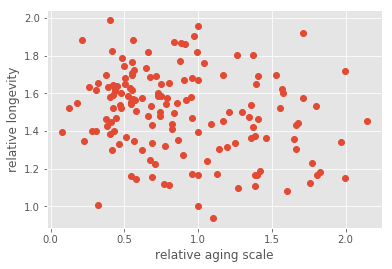

In [14]:
import matplotlib as mpl
%matplotlib inline
from matplotlib import pyplot as plt
plt.style.use('ggplot')
#import seaborn as sns
plt.plot(strain_df['scale_ratio'], strain_df['med_ratio'],'o')
#plt.xscale('log')
plt.xlabel('relative aging scale')
#plt.yscale('log')
plt.ylabel('relative longevity')

In [62]:
strain_df.loc['MG-WT']['beta']

153.7637447675589

### 3.2 Aging parameter space: lifespan, aging timescale, shape

__**shape = lifespan / scale**__

In [63]:
#candidates = ['ompL_new','pgi','uxaB_new','aqpZ','ascG','caiT_new','yagS','yfiD_new', 'appY']
candidates = list(strain_df.index)
strain_df['scale_ratio_log2'] = [np.log2(float(r)) for r in strain_df['scale_ratio']]
strain_df['lifespan_ratio_log2'] = [np.log2(float(r)) for r in strain_df['med_ratio']]
strain_df['shape_ratio_log2'] = [np.log2(float(r)) for r in strain_df['med_ratio']/strain_df['scale_ratio']]

rate_mg_wt = float(strain_df.loc['MG-WT']['rate'])
strain_df['rate_ratio_log2'] = [np.log2(float(r)/rate_mg_wt) for r in strain_df['rate']]

beta_mg_wt = float(strain_df.loc['MG-WT']['beta'])
strain_df['beta_ratio_log2'] =[np.log2(float(r)/beta_mg_wt) for r in strain_df['beta']]

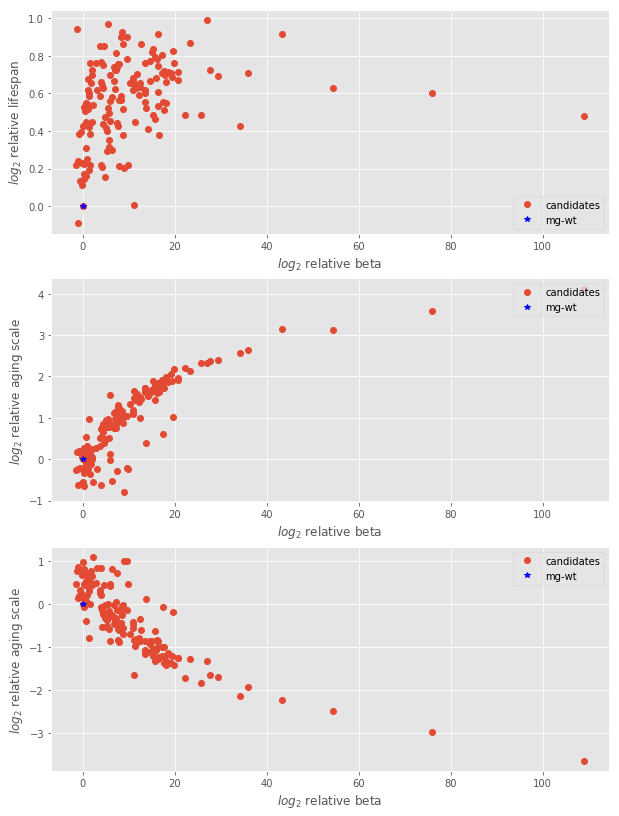

In [64]:
f, (ax1, ax2, ax3) = plt.subplots(3, sharex=False)


ax1.plot(strain_df.loc[candidates, 'beta_ratio_log2'],
         strain_df.loc[candidates, 'lifespan_ratio_log2'], 'o', label='candidates')

ax1.plot(strain_df.loc['MG-WT', 'beta_ratio_log2'],
         strain_df.loc['MG-WT', 'lifespan_ratio_log2'], '*b', label='mg-wt')

ax1.set_ylabel('$log_2$ relative lifespan')
ax1.set_xlabel('$log_2$ relative beta')
ax1.legend(loc=4)

ax2.plot(strain_df.loc[candidates, 'beta_ratio_log2'],
         strain_df.loc[candidates, 'shape_ratio_log2'], 'o', label='candidates')

ax2.plot(strain_df.loc['MG-WT', 'beta_ratio_log2'],
         strain_df.loc['MG-WT', 'shape_ratio_log2'], '*b', label='mg-wt')
ax2.set_xlabel('$log_2$ relative beta')
ax2.set_ylabel('$log_2$ relative aging scale ')

ax2.legend(loc=1)

ax3.plot(strain_df.loc[candidates, 'beta_ratio_log2'],
         strain_df.loc[candidates, 'scale_ratio_log2'], 'o', label='candidates')

ax3.plot(strain_df.loc['MG-WT', 'beta_ratio_log2'],
         strain_df.loc['MG-WT', 'scale_ratio_log2'], '*b', label='mg-wt')

ax3.set_xlabel('$log_2$ relative beta')
ax3.set_ylabel('$log_2$ relative aging scale ')

ax3.legend(loc=1)

f.set_size_inches(10,14)

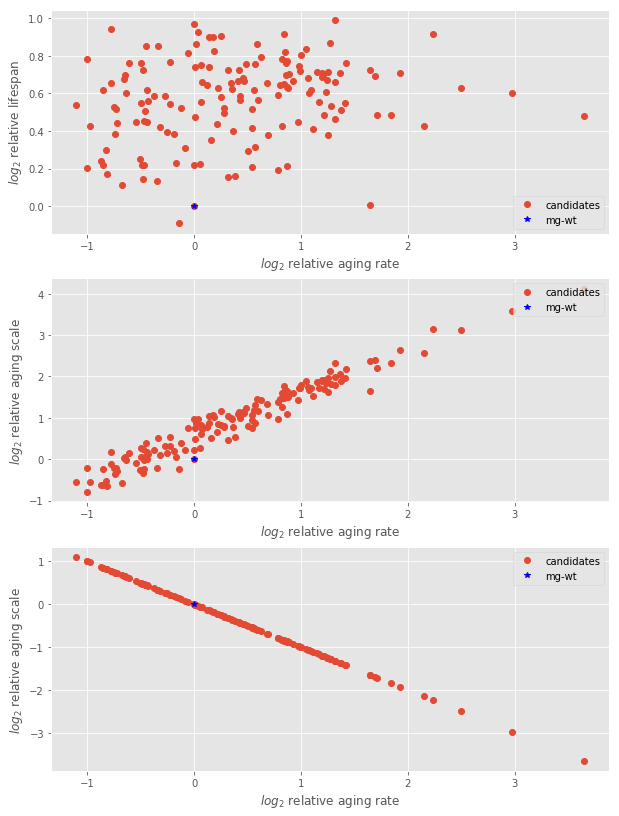

In [59]:
f, (ax1, ax2, ax3) = plt.subplots(3, sharex=False)


ax1.plot(strain_df.loc[candidates, 'rate_ratio_log2'],
         strain_df.loc[candidates, 'lifespan_ratio_log2'], 'o', label='candidates')

ax1.plot(strain_df.loc['MG-WT', 'rate_ratio_log2'],
         strain_df.loc['MG-WT', 'lifespan_ratio_log2'], '*b', label='mg-wt')

ax1.set_ylabel('$log_2$ relative lifespan')
ax1.set_xlabel('$log_2$ relative aging rate')
ax1.legend(loc=4)

ax2.plot(strain_df.loc[candidates, 'rate_ratio_log2'],
         strain_df.loc[candidates, 'shape_ratio_log2'], 'o', label='candidates')

ax2.plot(strain_df.loc['MG-WT', 'rate_ratio_log2'],
         strain_df.loc['MG-WT', 'shape_ratio_log2'], '*b', label='mg-wt')
ax2.set_xlabel('$log_2$ relative aging rate')
ax2.set_ylabel('$log_2$ relative aging scale ')

ax2.legend(loc=1)

ax3.plot(strain_df.loc[candidates, 'rate_ratio_log2'],
         strain_df.loc[candidates, 'scale_ratio_log2'], 'o', label='candidates')

ax3.plot(strain_df.loc['MG-WT', 'rate_ratio_log2'],
         strain_df.loc['MG-WT', 'scale_ratio_log2'], '*b', label='mg-wt')
ax3.set_xlabel('$log_2$ relative aging rate')
ax3.set_ylabel('$log_2$ relative aging scale ')

ax3.legend(loc=1)

f.set_size_inches(10,14)

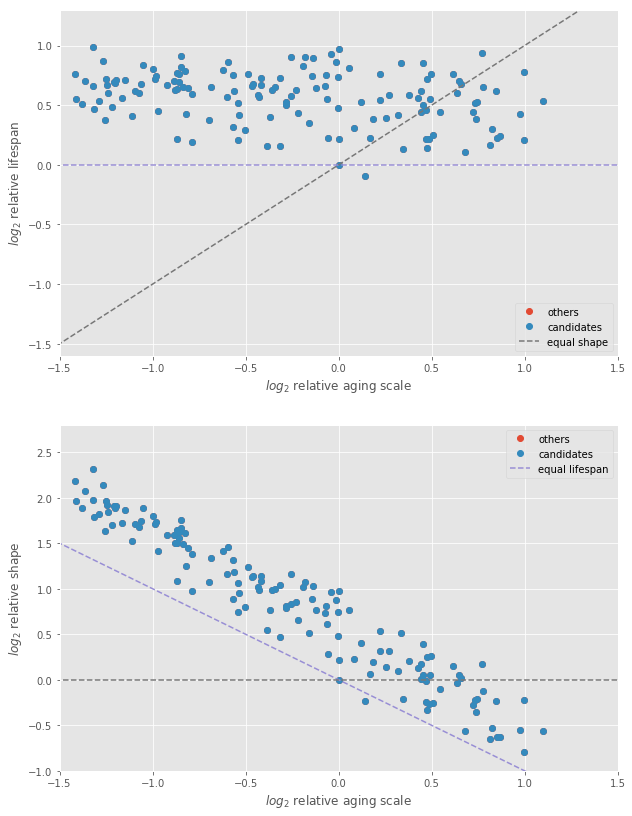

In [16]:
f, (ax1, ax2) = plt.subplots(2, sharex=False)

ax1.plot(strain_df['scale_ratio_log2'], 
         strain_df['lifespan_ratio_log2'],
         'o',label='others')
ax1.plot(strain_df.loc[candidates, 'scale_ratio_log2'],
         strain_df.loc[candidates, 'lifespan_ratio_log2'], 'o', label='candidates')
ax1.set_ylabel('$log_2$ relative lifespan')
ax1.set_xlabel('$log_2$ relative aging scale')
ax1.plot(np.arange(4,-4,-0.1), [0]*80, '--')
ax1.plot(np.arange(2,-3,-0.1), np.arange(2,-3,-0.1), '--', label='equal shape')
ax1.legend(loc=4)


ax2.plot(strain_df['scale_ratio_log2'], 
         strain_df['shape_ratio_log2'],
         'o',label='others')
ax2.plot(strain_df.loc[candidates, 'scale_ratio_log2'],
         strain_df.loc[candidates, 'shape_ratio_log2'], 'o', label='candidates')
ax2.set_xlabel('$log_2$ relative aging scale')
ax2.set_ylabel('$log_2$ relative shape ')
ax2.plot(np.arange(3,-4,-0.1), np.arange(-3,4,0.1), '--', label='equal lifespan')
ax2.plot(np.arange(4,-4,-0.1), [0]*80, '--')
ax2.legend(loc=1)

ax1.set_xlim([-1.5,1.5])
ax2.set_xlim([-1.5,1.5])
ax1.set_ylim([-1.6,1.3])
ax2.set_ylim([-1,2.8])


f.set_size_inches(10,14)

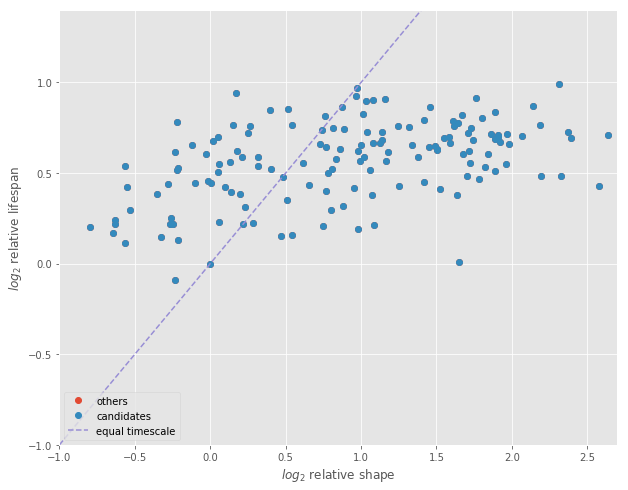

In [87]:
f, (ax1) = plt.subplots(1, sharex=False)

ax1.plot(strain_df['shape_ratio_log2'], 
         strain_df['lifespan_ratio_log2'],
         'o',label='others')
ax1.plot(strain_df.loc[candidates, 'shape_ratio_log2'],
         strain_df.loc[candidates, 'lifespan_ratio_log2'], 'o', label='candidates')
ax1.set_xlabel('$log_2$ relative shape')
ax1.set_ylabel('$log_2$ relative lifespan')
ax1.plot(np.arange(-1,1.5,0.1), np.arange(-1,1.5,0.1), '--', label='equal timescale')
ax1.legend(loc=3)

ax1.set_ylim([-1,1.4])
ax1.set_xlim([-1,2.7])


f.set_size_inches(10,8)

### 3.3 Longevity strains as candidate strains

In [88]:
strain_df.loc[candidates,['scale_ratio_log2','lifespan_ratio_log2','shape_ratio_log2']]

,scale_ratio_log2,lifespan_ratio_log2,shape_ratio_log2
yihV%202,0.120459,0.523195,0.402736
norW,-0.599195,0.565141,1.164336
norV,-1.198274,0.711431,1.909705
yncI,0.825763,0.296666,-0.529097
yecP,-0.158954,0.349586,0.508540
bipA,0.084672,0.311873,0.227201
pgi3,-0.824515,0.785495,1.610010
nirC,-0.923854,0.665627,1.589480
80%20MG%20yagS,0.468469,0.219519,-0.248950
ssuE%202,-1.111346,0.411870,1.523216


In [89]:
strain_df.loc[strain_df['lifespan_ratio_log2']>0.4,['scale_ratio_log2','lifespan_ratio_log2','shape_ratio_log2']]

,scale_ratio_log2,lifespan_ratio_log2,shape_ratio_log2
yihV%202,0.120459,0.523195,0.402736
norW,-0.599195,0.565141,1.164336
norV,-1.198274,0.711431,1.909705
pgi3,-0.824515,0.785495,1.610010
nirC,-0.923854,0.665627,1.589480
ssuE%202,-1.111346,0.411870,1.523216
yoaF,0.494770,0.760800,0.266030
ulaD,-0.624050,0.795252,1.419302
ycaD,0.721910,0.440815,-0.281095
nagZ,0.657077,0.677506,0.020429


# 4. Aging parameter C.I.s

### 4.1 Median lifespan: medians estimated non-parametrically from Kaplan-Meier, versus parametrically from GGM

In [90]:
from cohortMortalitySummary import KaplanMeier
def surv_prob_median(surv):
    return (surv.index[surv<0.5][0] + surv.index[surv>0.5][-1])*0.5
for strain in Fitted.keys():
    if strain in strain_error:
        print "jump ", strain
        continue
    KM = KaplanMeier(dfs_mortality[strain], tgs_mortality[strain])
    if KM['upper_ci'].iloc[-1]>0.5:
        print strain
    else:
        strain_df.loc[strain,'med_exp'] = surv_prob_median( KM['survivorship'] )
        strain_df.loc[strain,'med_exp_U95%'] = surv_prob_median( KM['upper_ci'] )
        strain_df.loc[strain,'med_exp_L95%'] = surv_prob_median( KM['lower_ci'] )
    

jump  ydjQ


Text(0,0.5,'model median lifespan (h)')

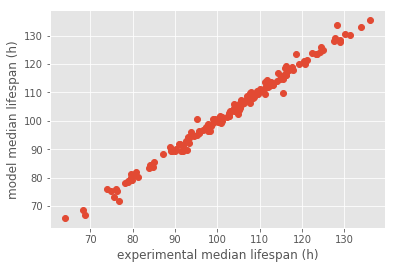

In [91]:
plt.plot([float(r) for r in strain_df['med_model']], strain_df['med_exp'],'o')
plt.xlabel('experimental median lifespan (h)')
plt.ylabel('model median lifespan (h)')


### 4.2 Calculating C.I.s of aging statistics from bootstrapped GGM parameters

In [92]:
for strain in Fitted.keys():
    if strain in strain_error:
        print "jump ", strain
        continue
    stats[strain]['smed'] = stats[strain]['median']*stats[strain]['rate']

for strain in Fitted.keys():
    if strain in strain_error:
        print "jump ", strain
        continue
    stats[strain]['inverse_eta'] = stats[strain]['beta']/stats[strain]['s']
    strain_df.loc[strain, 'inverse_eta'] = np.median(stats[strain]['beta']/stats[strain]['s'])
    strain_df.loc[strain,'model_type'] = Fitted[strain]['type']
    strain_df.loc[strain,'shape_exp'] = strain_df.loc[strain,'med_exp']*strain_df.loc[strain,'rate']
    strain_df.loc[strain,'shape_med'] = np.median(stats[strain]['median']*stats[strain]['rate'])
    
    strain_df.loc[strain,'med_model_L95%'] = 0.5*(np.sort(stats[strain]['median'])[int(np.floor(len(stats[strain]['median'])*0.025))]+np.sort(stats[strain]['median'])[1+int(np.floor(len(stats[strain]['median'])*0.025))])
    strain_df.loc[strain,'med_model_U95%'] = 0.5*(np.sort(stats[strain]['median'])[int(np.floor(len(stats[strain]['median'])*0.975))]+np.sort(stats[strain]['median'])[1+int(np.floor(len(stats[strain]['median'])*0.975))])
    
    strain_df.loc[strain,'shape_med_L95%'] = 0.5*(np.sort(stats[strain]['smed'])[int(np.floor(len(stats[strain]['smed'])*0.025))]+np.sort(stats[strain]['smed'])[1+int(np.floor(len(stats[strain]['smed'])*0.025))])
    strain_df.loc[strain,'shape_med_U95%'] = 0.5*(np.sort(stats[strain]['smed'])[int(np.floor(len(stats[strain]['smed'])*0.975))]+np.sort(stats[strain]['smed'])[1+int(np.floor(len(stats[strain]['smed'])*0.975))])
    
strain_df['shape_eta'] = [np.log(s*np.log(2)+1) for s in strain_df['inverse_eta']]

strain_df['scale_ratio_log2'] = [np.log2(float(r)) for r in strain_df['scale_ratio']]
strain_df['scale_ratio_log2_L95%'] = np.log2(strain_df.loc['MG-WT','rate'])-np.log2(strain_df.loc[:,'rate_U95%'])
strain_df['scale_ratio_log2_U95%'] = np.log2(strain_df.loc['MG-WT','rate'])-np.log2(strain_df.loc[:,'rate_L95%'])
strain_df['lifespan_ratio_log2'] = np.log2([lf/strain_df.loc['MG-WT','med_exp'] for lf in strain_df.loc[:,'med_exp']])
strain_df['lifespan_ratio_log2_L95%'] = np.log2(strain_df.loc[:,'med_exp_L95%']/strain_df.loc['MG-WT','med_exp'])
strain_df['lifespan_ratio_log2_U95%'] = np.log2(strain_df.loc[:,'med_exp_U95%']/strain_df.loc['MG-WT','med_exp']) 
strain_df['shape_ratio_log2'] = [np.log2(float(r)) for r in strain_df['med_ratio']/strain_df['scale_ratio']]
strain_df['shape_ratio_log2_L95%'] = np.log2(strain_df.loc[:,'shape_med_L95%']/strain_df.loc['MG-WT','shape_med'])
strain_df['shape_ratio_log2_U95%'] = np.log2(strain_df.loc[:,'shape_med_U95%']/strain_df.loc['MG-WT','shape_med'])

jump  ydjQ
jump  ydjQ


### 4.3 Drop data with too few imaging positions to avoid large C.I.s

In [93]:
for strain in dfs_mortality.keys():
    if strain in strain_error:
        print "jump ", strain
        continue
    if len(np.unique(dfs_mortality[strain]['fn'])) < 3:
        print strain
        strain_df.drop(strain, inplace=True)

ycaD
jump  ydjQ
hslR2
gspM
mprA
ynaA
melA
dcuA
bglF
gnsA
gltK
yjfJ
ybgD
70%20thiQ
uxaC3
alsB
xdhC
ydgT
syd
MG%20appY
yagL
ycfX
glpX
uxaA


### 4.4 Classify and plot strains based on significant differences in aging parameters

In [94]:
for strain in strain_df.index:
    for trait in ['rate', 'med_exp', 'shape_med']:
        if strain_df.loc[strain, trait+'_U95%'] < strain_df.loc['MG-WT', trait+'_L95%']:
            strain_df.loc[strain, trait+'_overlap_wt'] = -1
        elif strain_df.loc[strain, trait+'_L95%'] > strain_df.loc['MG-WT', trait+'_U95%']:
            strain_df.loc[strain, trait+'_overlap_wt'] = 1
        else:
            strain_df.loc[strain, trait+'_overlap_wt'] = 0

In [95]:
import seaborn as sns

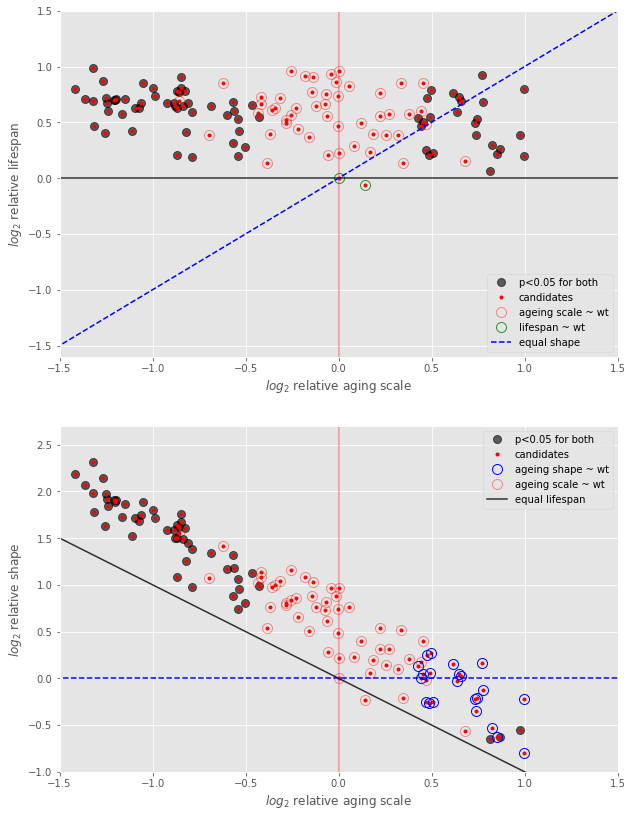

In [96]:
#candidates = ['ompL_new','pgi','uxaB_new','aqpZ','ascG','caiT_new','yagS','yfiD_new', 'appY']
candidates = list(strain_df.index)
rate_diff = set(strain_df.index[strain_df['rate_overlap_wt']!=0])
rate_non = set(strain_df.index[strain_df['rate_overlap_wt']==0])
lifespan_diff = set(strain_df.index[strain_df['med_exp_overlap_wt']!=0])
lifespan_non = set(strain_df.index[strain_df['med_exp_overlap_wt']==0])
shape_diff = set(strain_df.index[strain_df['shape_med_overlap_wt']!=0])
shape_non = set(strain_df.index[strain_df['shape_med_overlap_wt']==0])

f, (ax1, ax2) = plt.subplots(2, sharex=False)

ax1.plot(strain_df.loc[set.intersection(rate_diff, lifespan_diff),'scale_ratio_log2'], 
         strain_df.loc[set.intersection(rate_diff, lifespan_diff),'lifespan_ratio_log2'],
         'o',label='p<0.05 for both', color='k', markersize=8, alpha=0.6)
ax1.plot(strain_df.loc[candidates,'scale_ratio_log2'], 
         strain_df.loc[candidates,'lifespan_ratio_log2'],
         '.',label='candidates', color='r', markersize=6)
ax1.plot(strain_df.loc[set.difference(rate_non, lifespan_non), 'scale_ratio_log2'],
         strain_df.loc[set.difference(rate_non, lifespan_non), 'lifespan_ratio_log2'],
         'o',label='ageing scale ~ wt',markerfacecolor='none', markeredgecolor='r', alpha=0.4, markersize=10)
ax1.plot(strain_df.loc[lifespan_non, 'scale_ratio_log2'],
         strain_df.loc[lifespan_non, 'lifespan_ratio_log2'],
         'o',label='lifespan ~ wt', markerfacecolor='none', markeredgecolor='g', alpha=0.8, markersize=10)

ax1.set_ylabel('$log_2$ relative lifespan')
ax1.set_xlabel('$log_2$ relative aging scale')
ax1.plot(np.arange(4,-4,-0.1), [0]*80, '-', color='k', alpha=0.8)
ax1.plot( [0]*80, np.arange(4,-4,-0.1), '-', color='r', alpha=0.4)
ax1.plot(np.arange(2,-3,-0.1), np.arange(2,-3,-0.1), '--', color='b', label='equal shape')
ax1.legend(loc=4)


ax2.plot(strain_df.loc[set.intersection(shape_diff, rate_diff),'scale_ratio_log2'], 
         strain_df.loc[set.intersection(shape_diff, rate_diff),'shape_ratio_log2'],
         'o',label='p<0.05 for both', color='k', markersize=8, alpha=0.6)
ax2.plot(strain_df.loc[candidates,'scale_ratio_log2'], 
         strain_df.loc[candidates,'shape_ratio_log2'],
         '.',label='candidates', color='r', markersize=6)
ax2.plot(strain_df.loc[set.difference(shape_non, rate_non), 'scale_ratio_log2'],
         strain_df.loc[set.difference(shape_non, rate_non), 'shape_ratio_log2'],
        'o',label='ageing shape ~ wt',markerfacecolor='none', markeredgecolor='b', markersize=10)
ax2.plot(strain_df.loc[rate_non, 'scale_ratio_log2'],
         strain_df.loc[rate_non, 'shape_ratio_log2'],
        'o',label='ageing scale ~ wt',markerfacecolor='none', markeredgecolor='r', alpha=0.4, markersize=10)
ax2.set_xlabel('$log_2$ relative aging scale')
ax2.set_ylabel('$log_2$ relative shape ')
ax2.plot(np.arange(3,-4,-0.1), np.arange(-3,4,0.1), '-',color='k', alpha=0.8, label='equal lifespan')
ax2.plot( [0]*80, np.arange(4,-4,-0.1), '-', color='r', alpha=0.4)
ax2.plot(np.arange(4,-4,-0.1), [0]*80, '--',color='b')
ax2.legend(loc=1)

ax1.set_xlim([-1.5,1.5])
ax2.set_xlim([-1.5,1.5])
ax1.set_ylim([-1.6,1.5])
ax2.set_ylim([-1,2.7])


f.set_size_inches(10,14)

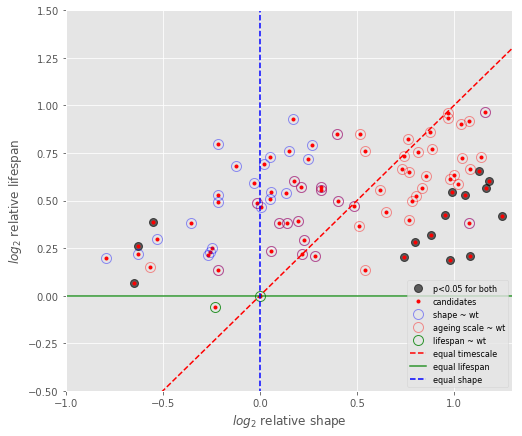

In [97]:
f, (ax1) = plt.subplots(1, sharex=False)

ax1.plot(strain_df.loc[set.difference(set.intersection(shape_diff, lifespan_diff),rate_non),'shape_ratio_log2'], 
         strain_df.loc[set.difference(set.intersection(shape_diff, lifespan_diff),rate_non),'lifespan_ratio_log2'],
         'o',label='p<0.05 for both', color='k', markersize=8, alpha=0.6)
ax1.plot(strain_df.loc[candidates,'shape_ratio_log2'], 
         strain_df.loc[candidates,'lifespan_ratio_log2'],
         '.',label='candidates', color='r', markersize=6)
ax1.plot(strain_df.loc[set.difference(shape_non, lifespan_non), 'shape_ratio_log2'],
         strain_df.loc[set.difference(shape_non, lifespan_non), 'lifespan_ratio_log2'],
         'o',label='shape ~ wt',markerfacecolor='none', markeredgecolor='b', alpha=0.4, markersize=10)
ax1.plot(strain_df.loc[set.difference(rate_non,lifespan_non), 'shape_ratio_log2'],
         strain_df.loc[set.difference(rate_non,lifespan_non), 'lifespan_ratio_log2'],
        'o',label='ageing scale ~ wt',markerfacecolor='none', markeredgecolor='r', alpha=0.4, markersize=10)
ax1.plot(strain_df.loc[lifespan_non, 'shape_ratio_log2'],
         strain_df.loc[lifespan_non, 'lifespan_ratio_log2'],
         'o',label='lifespan ~ wt', markerfacecolor='none', markeredgecolor='g', alpha=0.8, markersize=10)


ax1.set_xlabel('$log_2$ relative shape')
ax1.set_ylabel('$log_2$ relative lifespan')
ax1.plot(np.arange(-1,1.5,0.1), np.arange(-1,1.5,0.1), 'r--', label='equal timescale')
ax1.plot(np.arange(4,-4,-0.1),[0]*80, '-',color='g', alpha=0.8, label='equal lifespan')
ax1.plot([0]*80,np.arange(4,-4,-0.1),  '--',color='b', label='equal shape')
ax1.legend(loc=4, fontsize=8)

ax1.set_ylim([-0.5,1.5])
ax1.set_xlim([-1,1.3])


f.set_size_inches(8,7)

# 5. What is shape? A function of Gompertz intercept

### 5.1 Analytical formulation of shape using Gamma-Gompertz parameters: $ln(\frac{\beta}{s}ln2+1)$

### 5.2 Analytical vs experimental shape

__Experimental shape could be calculated using lifespan distribution without assuming parametric models__

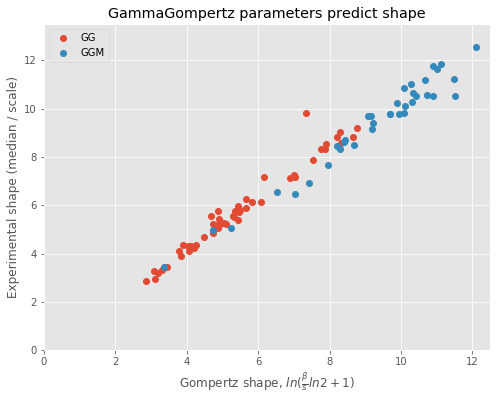

In [98]:
f, ( ax1) = plt.subplots(1, sharex=False)

ax1.plot(strain_df.loc[strain_df['model_type']=='GG','shape_eta'],
         strain_df.loc[strain_df['model_type']=='GG','shape_exp'],'o',label='GG')
ax1.plot(strain_df.loc[strain_df['model_type']=='GGM','shape_eta'],
         strain_df.loc[strain_df['model_type']=='GGM','shape_exp'],'o',label='GGM')
ax1.set_xlabel('Gompertz median')
ax1.set_ylabel('Experimental shape (median / scale)')
ax1.set_xlim([0,12.5])
ax1.set_ylim([0,13.5])
ax1.legend(loc=2)

ax1.set_xlabel(r'Gompertz shape, $ln(\frac{\beta}{s}ln2+1)$')
ax1.set_title('GammaGompertz parameters predict shape')

f.set_size_inches(8,6)

### 5.3 Analytical vs GGM model shape

**Shape can also be calculated using fitted GGM models. Ignoring Makeham term do not make much difference**

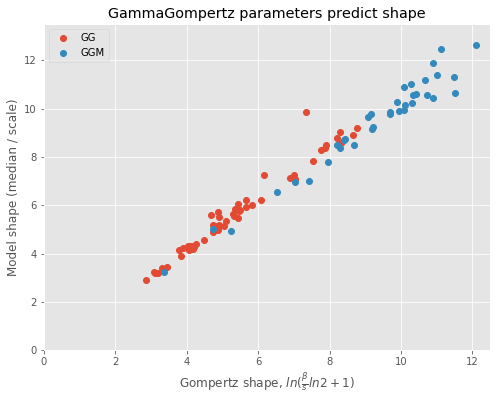

In [99]:
f, ( ax1) = plt.subplots(1, sharex=False)

ax1.plot(strain_df.loc[strain_df['model_type']=='GG','shape_eta'],
         strain_df.loc[strain_df['model_type']=='GG','shape_med'],'o',label='GG')
ax1.plot(strain_df.loc[strain_df['model_type']=='GGM','shape_eta'],
         strain_df.loc[strain_df['model_type']=='GGM','shape_med'],'o',label='GGM')
ax1.set_xlabel('Gompertz median')
ax1.set_ylabel('Model shape (median / scale)')
ax1.set_xlim([0,12.5])
ax1.set_ylim([0,13.5])
ax1.legend(loc=2)

ax1.set_xlabel(r'Gompertz shape, $ln(\frac{\beta}{s}ln2+1)$')

ax1.set_title('GammaGompertz parameters predict shape')

f.set_size_inches(8,6)

### 5.4 Shape and Gompertz intercept $\eta = \frac{\beta}{s}$

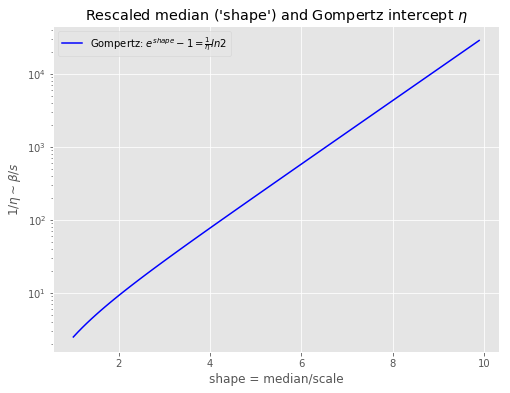

In [100]:
ax2 = plt.gca()
ax2.plot(np.arange(1,10,0.1), [(np.exp(s)-1)/np.log(2) for s in np.arange(1,10,0.1)], 'b',
         label=r'Gompertz: $e^{shape}-1 = \frac{1}{\eta}ln2$')
ax2.set_yscale('log')
ax2.set_ylabel('$1/\\eta \\sim \\beta/s$')
ax2.set_xlabel('shape = median/scale')
ax2.legend(loc=0)
ax2.set_title('Rescaled median (\'shape\') and Gompertz intercept $\eta$')

plt.gcf().set_size_inches(8,6)

## 6. Saving and replotting aging parameters using only initially selected mutants

### 6.0 Saving results so far

In [101]:
strain_df[['scale','scale_ratio','scale_ratio_log2','rate_overlap_wt',
           'med_exp','med_exp_overlap_wt','med_model','med_ratio','lifespan_ratio_log2',
           'shape_med','shape_med_overlap_wt','shape_exp','shape_eta','inverse_eta','shape_ratio_log2']].to_csv('/app/src/ms2_post_analysis/Aging parameters.csv')
strain_df[['scale_ratio_log2','scale','lifespan_ratio_log2','med_exp',
           'shape_ratio_log2','shape_exp',
           'rate_overlap_wt','med_exp_overlap_wt','shape_med_overlap_wt']].to_csv(
                '/app/src/ms2_post_analysis/Mutant effects on aging parameters.csv')

## waiting candidates

In [ ]:
strain_df.loc[['MG-WT']+candidates, ['model type']+
              list(np.ravel([[trait,trait+'_L95%',trait+'_U95%'] for trait in ['rate','beta','s','lambda']]))].to_csv(
                'csv/Candidates aging parameters.csv')
strain_df.loc[['MG-WT']+candidates, ['model type']+
              list(np.ravel([[trait,trait+'_L95%',trait+'_U95%'] for trait in ['rate','beta','s','lambda']]))]

In [ ]:
for strain in Fitted.keys():
    if strain in strain_error:
        print "jump ", strain
        continue
    quantiles[strain].to_csv('/app/src/ms2_post_analysis/bootstrap/'+strain+'.csv')

### 6.1 Growth yields are only measured for the initially selected mutants

In [102]:
yield_df = pandas.read_csv('yield_all_strains.csv',sep=',')
yield_df.set_index('Unnamed: 0', inplace=True)

In [104]:
initial_genes = list(yield_df.index)
initial_strains = [strain for strain in strain_df.index
                   if strain.split('_')[0] in initial_genes]
other_strains = [strain for strain in strain_df.index
                   if strain.split('_')[0] not in initial_genes]
for strain in initial_strains:
    print strain
    strain_df.loc[strain, 'yield_mean'] = np.mean(np.mean(yield_df.loc[strain.split('%20')[0], :]))
    strain_df.loc[strain, 'yield_std'] = np.mean(np.std(yield_df.loc[strain.split('%20')[0], :]))


norW
norV
yncI
yecP
bipA
nirC
ycaL
ulaD
nagZ
sspA
eptA
nagK
ydjQ
MG-WT
yfbM
ptsH
ydjK
pfkA
hycA
gspF
gspL
ygjP
fruR
ldcC
tyrB
fruB
phnH
ybaJ
paoB
ytfF
cbpM
caiT
yobH
intG
yhbW
caiB
dcp
recF
yqjE
glf
mhpB
gltL
fixC
gltD
ybbP
yafV
yhbS
yggE
yggF
citT
napC
appB
appA
yphG
pflD
pflC
ykfF
ykfI
yjhG
rsd
treC
ybdG
agaR
yicH
agaV
yihS
tdcE
dnaT
yiaW
yjgB
flu
eutQ
crcA
xdhB
yagH
yidH
yjfC
fkpA
yagQ
cynX
paaC
yhbP
idnD
nsrR
sgcQ
mtlD
ssuA
yeeW
cstA
yigL
yafX
yjeL
yigZ


### 6.2 Three sub-types are outlined: mutants with wildtype level lifespan or aging scale or shape

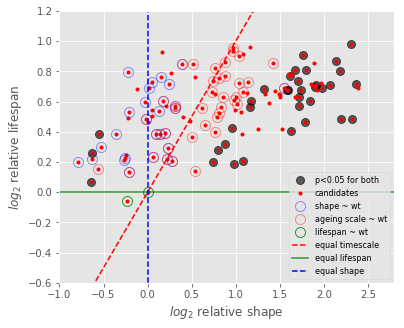

In [105]:
f, (ax1) = plt.subplots(1, sharex=False)

ax1.plot(strain_df.loc[set.difference(set.intersection(set(initial_strains), shape_diff, lifespan_diff),rate_non),'shape_ratio_log2'], 
         strain_df.loc[set.difference(set.intersection(set(initial_strains), shape_diff, lifespan_diff),rate_non),'lifespan_ratio_log2'],
         'o',label='p<0.05 for both', color='k', markersize=8, alpha=0.6)
ax1.plot(strain_df.loc[candidates,'shape_ratio_log2'], 
         strain_df.loc[candidates,'lifespan_ratio_log2'],
         '.',label='candidates', color='r', markersize=6)
ax1.plot(strain_df.loc[set.intersection(set(initial_strains), set.difference(shape_non, lifespan_non)), 'shape_ratio_log2'],
         strain_df.loc[set.intersection(set(initial_strains), set.difference(shape_non, lifespan_non)), 'lifespan_ratio_log2'],
         'o',label='shape ~ wt',markerfacecolor='none', markeredgecolor='b', alpha=0.4, markersize=10)
ax1.plot(strain_df.loc[set.intersection(set(initial_strains), set.difference(rate_non,lifespan_non)), 'shape_ratio_log2'],
         strain_df.loc[set.intersection(set(initial_strains), set.difference(rate_non,lifespan_non)), 'lifespan_ratio_log2'],
        'o',label='ageing scale ~ wt',markerfacecolor='none', markeredgecolor='r', alpha=0.4, markersize=10)
ax1.plot(strain_df.loc[set.intersection(set(initial_strains), lifespan_non), 'shape_ratio_log2'],
         strain_df.loc[set.intersection(set(initial_strains), lifespan_non), 'lifespan_ratio_log2'],
         'o',label='lifespan ~ wt', markerfacecolor='none', markeredgecolor='g', alpha=0.8, markersize=10)


ax1.set_xlabel('$log_2$ relative shape')
ax1.set_ylabel('$log_2$ relative lifespan')
ax1.plot(np.arange(-1,1.5,0.1), np.arange(-1,1.5,0.1), 'r--', label='equal timescale')
ax1.plot(np.arange(4,-4,-0.1),[0]*80, '-',color='g', alpha=0.8, label='equal lifespan')
ax1.plot([0]*80,np.arange(4,-4,-0.1),  '--',color='b', label='equal shape')
ax1.legend(loc=4, fontsize=8)

ax1.set_ylim([-0.6,1.2])
ax1.set_xlim([-1,2.8])


f.set_size_inches(6,5)

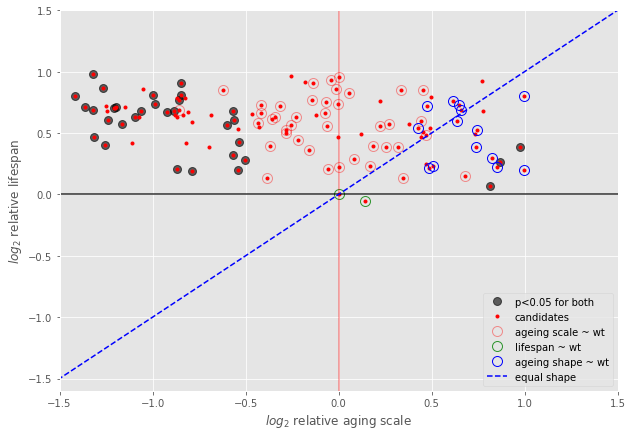

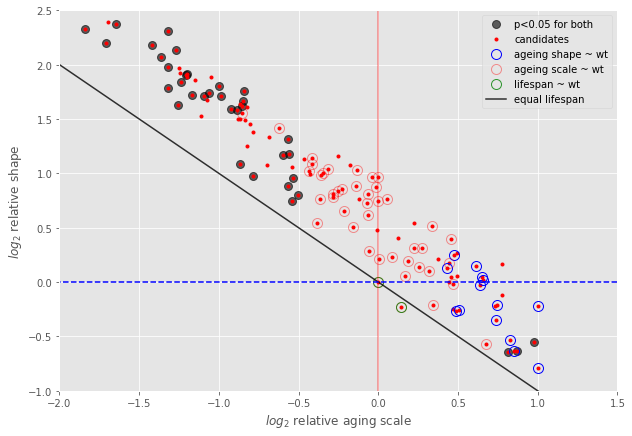

In [106]:
#candidates = ['ompL_new','pgi','uxaB_new','aqpZ','ascG','caiT_new','yagS','yfiD_new', 'appY']
candidates = list(strain_df.index)

rate_diff = set(strain_df.index[strain_df['rate_overlap_wt']!=0])
rate_non = set(strain_df.index[strain_df['rate_overlap_wt']==0])
lifespan_diff = set(strain_df.index[strain_df['med_exp_overlap_wt']!=0])
lifespan_non = set(strain_df.index[strain_df['med_exp_overlap_wt']==0])
shape_diff = set(strain_df.index[strain_df['shape_med_overlap_wt']!=0])
shape_non = set(strain_df.index[strain_df['shape_med_overlap_wt']==0])

f1, (ax1) = plt.subplots(1, sharex=False)
f2, (ax2) = plt.subplots(1, sharex=False)

ax1.plot(strain_df.loc[set.intersection(set(initial_strains), rate_diff, lifespan_diff, shape_diff),'scale_ratio_log2'], 
         strain_df.loc[set.intersection(set(initial_strains), rate_diff, lifespan_diff, shape_diff),'lifespan_ratio_log2'],
         'o',label='p<0.05 for both', color='k', markersize=8, alpha=0.6)
ax1.plot(strain_df.loc[candidates,'scale_ratio_log2'], 
         strain_df.loc[candidates,'lifespan_ratio_log2'],
         '.',label='candidates', color='r', markersize=6)
ax1.plot(strain_df.loc[set.intersection(set(initial_strains), set.difference(rate_non, lifespan_non)), 'scale_ratio_log2'],
         strain_df.loc[set.intersection(set(initial_strains), set.difference(rate_non, lifespan_non)), 'lifespan_ratio_log2'],
         'o',label='ageing scale ~ wt',markerfacecolor='none', markeredgecolor='r', alpha=0.4, markersize=10)
ax1.plot(strain_df.loc[set.intersection(set(initial_strains),lifespan_non), 'scale_ratio_log2'],
         strain_df.loc[set.intersection(set(initial_strains),lifespan_non), 'lifespan_ratio_log2'],
         'o',label='lifespan ~ wt', markerfacecolor='none', markeredgecolor='g', alpha=0.8, markersize=10)
ax1.plot(strain_df.loc[set.intersection(set(initial_strains), set.difference(shape_non, rate_non), lifespan_diff), 'scale_ratio_log2'],
         strain_df.loc[set.intersection(set(initial_strains), set.difference(shape_non, rate_non), lifespan_diff), 'lifespan_ratio_log2'],
        'o',label='ageing shape ~ wt',markerfacecolor='none', markeredgecolor='b', markersize=10)

ax1.set_ylabel('$log_2$ relative lifespan')
ax1.set_xlabel('$log_2$ relative aging scale')
ax1.plot(np.arange(4,-4,-0.1), [0]*80, '-', color='k', alpha=0.8)
ax1.plot( [0]*80, np.arange(4,-4,-0.1), '-', color='r', alpha=0.4)
ax1.plot(np.arange(2,-3,-0.1), np.arange(2,-3,-0.1), '--', color='b', label='equal shape')
ax1.legend(loc=4)


ax2.plot(strain_df.loc[set.intersection(set(initial_strains), shape_diff, rate_diff, lifespan_diff),'scale_ratio_log2'], 
         strain_df.loc[set.intersection(set(initial_strains), shape_diff, rate_diff, lifespan_diff),'shape_ratio_log2'],
         'o',label='p<0.05 for both', color='k', markersize=8, alpha=0.6)
ax2.plot(strain_df.loc[candidates,'scale_ratio_log2'], 
         strain_df.loc[candidates,'shape_ratio_log2'],
         '.',label='candidates', color='r', markersize=6)
ax2.plot(strain_df.loc[set.intersection(set(initial_strains), set.difference(shape_non, rate_non)), 'scale_ratio_log2'],
         strain_df.loc[set.intersection(set(initial_strains), set.difference(shape_non, rate_non)), 'shape_ratio_log2'],
        'o',label='ageing shape ~ wt',markerfacecolor='none', markeredgecolor='b', markersize=10)
ax2.plot(strain_df.loc[set.intersection(set(initial_strains), rate_non), 'scale_ratio_log2'],
         strain_df.loc[set.intersection(set(initial_strains), rate_non), 'shape_ratio_log2'],
        'o',label='ageing scale ~ wt',markerfacecolor='none', markeredgecolor='r', alpha=0.4, markersize=10)
ax2.plot(strain_df.loc[set.intersection(set(initial_strains),lifespan_non), 'scale_ratio_log2'],
         strain_df.loc[set.intersection(set(initial_strains),lifespan_non), 'shape_ratio_log2'],
         'o',label='lifespan ~ wt', markerfacecolor='none', markeredgecolor='g', alpha=0.8, markersize=10)
ax2.set_xlabel('$log_2$ relative aging scale')
ax2.set_ylabel('$log_2$ relative shape ')
ax2.plot(np.arange(3,-4,-0.1), np.arange(-3,4,0.1), '-',color='k', alpha=0.8, label='equal lifespan')
ax2.plot( [0]*80, np.arange(4,-4,-0.1), '-', color='r', alpha=0.4)
ax2.plot(np.arange(4,-4,-0.1), [0]*80, '--',color='b')
ax2.legend(loc=1)

ax1.set_xlim([-1.5,1.5])
ax2.set_xlim([-2.0,1.5])
ax1.set_ylim([-1.6,1.5])
ax2.set_ylim([-1,2.5])


f2.set_size_inches(10,7)
f1.set_size_inches(10,7)

### 6.3 Only two sub-types are outlined: mutants with wildtype level lifespan or aging scale

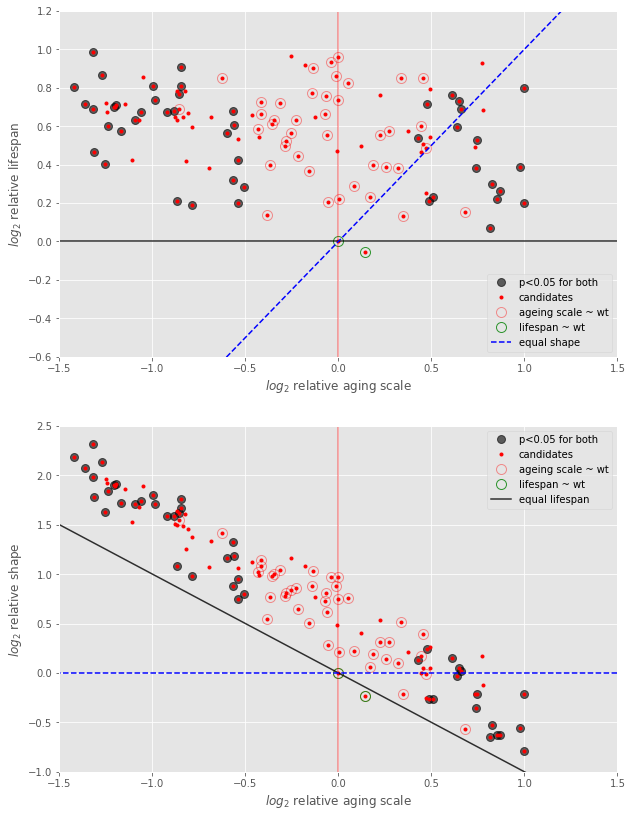

In [107]:
#candidates = ['ompL_new','pgi','uxaB_new','aqpZ','ascG','caiT_new','yagS','yfiD_new', 'appY']
candidates = list(strain_df.index)
rate_diff = set(strain_df.index[strain_df['rate_overlap_wt']!=0])
rate_non = set(strain_df.index[strain_df['rate_overlap_wt']==0])
lifespan_diff = set(strain_df.index[strain_df['med_exp_overlap_wt']!=0])
lifespan_non = set(strain_df.index[strain_df['med_exp_overlap_wt']==0])
shape_diff = set(strain_df.index[strain_df['shape_med_overlap_wt']!=0])
shape_non = set(strain_df.index[strain_df['shape_med_overlap_wt']==0])

f, (ax1, ax2) = plt.subplots(2, sharex=False)

ax1.plot(strain_df.loc[set.intersection(set(initial_strains), rate_diff, lifespan_diff),'scale_ratio_log2'], 
         strain_df.loc[set.intersection(set(initial_strains), rate_diff, lifespan_diff),'lifespan_ratio_log2'],
         'o',label='p<0.05 for both', color='k', markersize=8, alpha=0.6)
ax1.plot(strain_df.loc[candidates,'scale_ratio_log2'], 
         strain_df.loc[candidates,'lifespan_ratio_log2'],
         '.',label='candidates', color='r', markersize=6)
ax1.plot(strain_df.loc[set.intersection(set(initial_strains), set.difference(rate_non, lifespan_non)), 'scale_ratio_log2'],
         strain_df.loc[set.intersection(set(initial_strains), set.difference(rate_non, lifespan_non)), 'lifespan_ratio_log2'],
         'o',label='ageing scale ~ wt',markerfacecolor='none', markeredgecolor='r', alpha=0.4, markersize=10)
ax1.plot(strain_df.loc[set.intersection(set(initial_strains),lifespan_non), 'scale_ratio_log2'],
         strain_df.loc[set.intersection(set(initial_strains),lifespan_non), 'lifespan_ratio_log2'],
         'o',label='lifespan ~ wt', markerfacecolor='none', markeredgecolor='g', alpha=0.8, markersize=10)

ax1.set_ylabel('$log_2$ relative lifespan')
ax1.set_xlabel('$log_2$ relative aging scale')
ax1.plot(np.arange(4,-4,-0.1), [0]*80, '-', color='k', alpha=0.8)
ax1.plot( [0]*80, np.arange(4,-4,-0.1), '-', color='r', alpha=0.4)
ax1.plot(np.arange(2,-3,-0.1), np.arange(2,-3,-0.1), '--', color='b', label='equal shape')
ax1.legend(loc=4)


ax2.plot(strain_df.loc[set.intersection(set(initial_strains), rate_diff, lifespan_diff),'scale_ratio_log2'], 
         strain_df.loc[set.intersection(set(initial_strains), rate_diff, lifespan_diff),'shape_ratio_log2'],
         'o',label='p<0.05 for both', color='k', markersize=8, alpha=0.6)
ax2.plot(strain_df.loc[candidates,'scale_ratio_log2'], 
         strain_df.loc[candidates,'shape_ratio_log2'],
         '.',label='candidates', color='r', markersize=6)
ax2.plot(strain_df.loc[set.intersection(set(initial_strains), rate_non), 'scale_ratio_log2'],
         strain_df.loc[set.intersection(set(initial_strains), rate_non), 'shape_ratio_log2'],
        'o',label='ageing scale ~ wt',markerfacecolor='none', markeredgecolor='r', alpha=0.4, markersize=10)
ax2.plot(strain_df.loc[set.intersection(set(initial_strains),lifespan_non), 'scale_ratio_log2'],
         strain_df.loc[set.intersection(set(initial_strains),lifespan_non), 'shape_ratio_log2'],
         'o',label='lifespan ~ wt', markerfacecolor='none', markeredgecolor='g', alpha=0.8, markersize=10)
ax2.set_xlabel('$log_2$ relative aging scale')
ax2.set_ylabel('$log_2$ relative shape ')
ax2.plot(np.arange(3,-4,-0.1), np.arange(-3,4,0.1), '-',color='k', alpha=0.8, label='equal lifespan')
ax2.plot( [0]*80, np.arange(4,-4,-0.1), '-', color='r', alpha=0.4)
ax2.plot(np.arange(4,-4,-0.1), [0]*80, '--',color='b')
ax2.legend(loc=1)

ax1.set_xlim([-1.5,1.5])
ax2.set_xlim([-1.5,1.5])
ax1.set_ylim([-0.6,1.2])
ax2.set_ylim([-1,2.5])


f.set_size_inches(10,14)

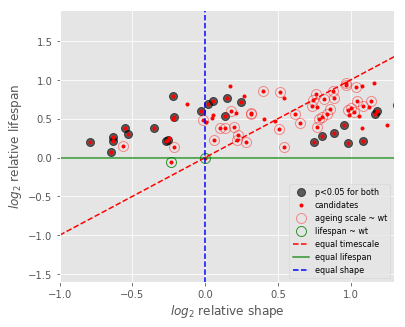

In [108]:
f, (ax1) = plt.subplots(1, sharex=False)

ax1.plot(strain_df.loc[set.difference(set.intersection(set(initial_strains), lifespan_diff),rate_non),'shape_ratio_log2'], 
         strain_df.loc[set.difference(set.intersection(set(initial_strains), lifespan_diff),rate_non),'lifespan_ratio_log2'],
         'o',label='p<0.05 for both', color='k', markersize=8, alpha=0.6)
ax1.plot(strain_df.loc[candidates,'shape_ratio_log2'], 
         strain_df.loc[candidates,'lifespan_ratio_log2'],
         '.',label='candidates', color='r', markersize=6)
ax1.plot(strain_df.loc[set.intersection(set(initial_strains), set.difference(rate_non,lifespan_non)), 'shape_ratio_log2'],
         strain_df.loc[set.intersection(set(initial_strains), set.difference(rate_non,lifespan_non)), 'lifespan_ratio_log2'],
        'o',label='ageing scale ~ wt',markerfacecolor='none', markeredgecolor='r', alpha=0.4, markersize=10)
ax1.plot(strain_df.loc[set.intersection(set(initial_strains), lifespan_non), 'shape_ratio_log2'],
         strain_df.loc[set.intersection(set(initial_strains), lifespan_non), 'lifespan_ratio_log2'],
         'o',label='lifespan ~ wt', markerfacecolor='none', markeredgecolor='g', alpha=0.8, markersize=10)


ax1.set_xlabel('$log_2$ relative shape')
ax1.set_ylabel('$log_2$ relative lifespan')
ax1.plot(np.arange(-1,1.5,0.1), np.arange(-1,1.5,0.1), 'r--', label='equal timescale')
ax1.plot(np.arange(4,-4,-0.1),[0]*80, '-',color='g', alpha=0.8, label='equal lifespan')
ax1.plot([0]*80,np.arange(4,-4,-0.1),  '--',color='b', label='equal shape')
ax1.legend(loc=4, fontsize=8)

ax1.set_ylim([-1.6,1.9])
ax1.set_xlim([-1,1.3])


f.set_size_inches(6,5)

# 7. Publication quality exhibitions of mutant lifespan distributions 

In [109]:
import matplotlib as mpl
from matplotlib import pyplot as plt
import seaborn as sns
sns.set_context("poster")
sns.set_style("white")

In [110]:
coordinates = dict()
for strain in initial_strains:
    coordinates[strain] = (strain_df.loc[strain,'scale_ratio_log2'], strain_df.loc[strain,'lifespan_ratio_log2'])
def distance(strain1, strain2):
    return np.sqrt(np.sum(np.power(coordinates[strain1][i]-coordinates[strain2][i], 2) for i in range(2)))

grid_positions = dict()
vectors = dict()
to_assign = set(initial_strains)
grid_positions['MG-WT']=(0,0)
#to_assign.remove('WT')
while len(to_assign) > 0:
    #finding the next strain to assign: closed to already assigned strains
    min_dist2grid = 99.0
    next_strain2assign = ''
    for strain in to_assign:
        dist2grid = np.min([distance(strain,assigned) for assigned in grid_positions.keys()])
        if dist2grid < min_dist2grid:
            next_strain2assign = strain
            min_dist2grid = dist2grid
    
    if next_strain2assign == '':
        break
    else:
        print next_strain2assign
        
    for assigned in grid_positions.keys():
        if distance(next_strain2assign,assigned) == min_dist2grid:
            #assign next_strain2assign next to its closest assignd neighbor
            dist_x = np.abs(coordinates[next_strain2assign][0]-coordinates[assigned][0])
            dist_y = np.abs(coordinates[next_strain2assign][1]-coordinates[assigned][1])
            
            if dist_x > dist_y:
                grid_positions[next_strain2assign] = (grid_positions[assigned][0], 
                                                      grid_positions[assigned][1]+
                                                     int((coordinates[next_strain2assign][1]-
                                                          coordinates[assigned][1])/
                                                         dist_y)
                                                     )
            else:
                try:
                    grid_positions[next_strain2assign] = (grid_positions[assigned][0]+
                                                        int((coordinates[next_strain2assign][0]-
                                                          coordinates[assigned][0])/dist_x), 
                                                      grid_positions[assigned][1])
                except:
                    grid_positions[next_strain2assign] = (0,0)
                    
            vectors[next_strain2assign] = (assigned, (coordinates[next_strain2assign][0]-coordinates[assigned][0],
                                    coordinates[next_strain2assign][1]-coordinates[assigned][1]))
            print assigned, grid_positions[assigned], '->', next_strain2assign, grid_positions[next_strain2assign],coordinates[next_strain2assign]
            to_assign.remove(next_strain2assign)
            
            
            
            

/app/miniconda/envs/py27/lib/python2.7/site-packages/ipykernel_launcher.py:5: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  """
/app/miniconda/envs/py27/lib/python2.7/site-packages/ipykernel_launcher.py:44: RuntimeWarning: invalid value encountered in double_scalars


MG-WT
MG-WT (0, 0) -> MG-WT (0, 0) (0.0, 0.0)
ycaL
MG-WT (0, 0) -> ycaL (0, -1) (0.1410646999463296, -0.057022304458653396)
ykfF
MG-WT (0, 0) -> ykfF (-1, 0) (-0.05665989646627258, 0.20635360578890183)
agaR
ykfF (-1, 0) -> agaR (-1, 1) (0.0028500740879576648, 0.22098748913361174)
bipA
agaR (-1, 1) -> bipA (-1, 2) (0.08467235949339617, 0.29059699513735454)
pflD
bipA (-1, 2) -> pflD (-1, 1) (0.17002891538303555, 0.23234232384423892)
treC
bipA (-1, 2) -> treC (0, 2) (0.18713640680095073, 0.39487846399662774)
agaV
treC (0, 2) -> agaV (0, 1) (0.256119367515842, 0.3844252410134848)
yeeW
agaV (0, 1) -> yeeW (0, 0) (0.3210516180450101, 0.3842342729389669)
eptA
treC (0, 2) -> eptA (1, 2) (0.2249161026085257, 0.5558264293081195)
dcp
eptA (1, 2) -> dcp (1, 3) (0.2725742060225542, 0.573073562964074)
hycA
dcp (1, 3) -> hycA (1, 2) (0.4282555192053177, 0.5379333381202505)
recF
hycA (1, 2) -> recF (2, 2) (0.4442741901988092, 0.6014312254215929)
gspL
hycA (1, 2) -> gspL (2, 2) (0.46909099049334413, 0.

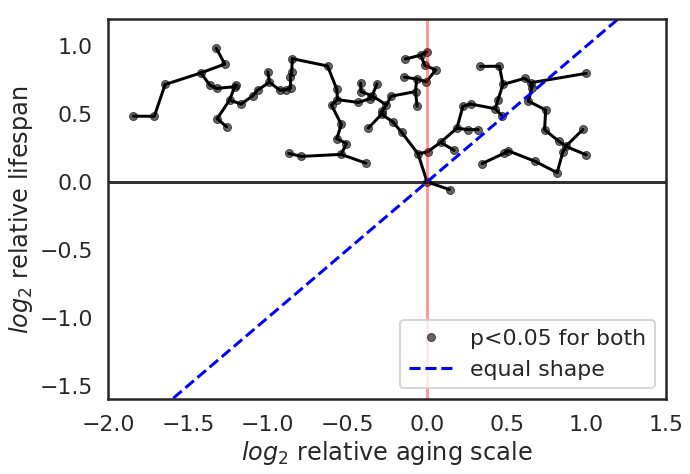

In [111]:
f, (ax1) = plt.subplots(1, sharex=False)

ax1.plot(strain_df.loc[set(initial_strains),'scale_ratio_log2'], 
         strain_df.loc[set(initial_strains),'lifespan_ratio_log2'],
         'o',label='p<0.05 for both', color='k', markersize=8, alpha=0.6)
for strain, (start, vector) in vectors.items():
    ax1.plot([coordinates[start][0], coordinates[strain][0]], [coordinates[start][1], coordinates[strain][1]], 'k-')

ax1.set_ylabel('$log_2$ relative lifespan')
ax1.set_xlabel('$log_2$ relative aging scale')
ax1.plot(np.arange(4,-4,-0.1), [0]*80, '-', color='k', alpha=0.8)
ax1.plot( [0]*80, np.arange(4,-4,-0.1), '-', color='r', alpha=0.4)
ax1.plot(np.arange(2,-3,-0.1), np.arange(2,-3,-0.1), '--', color='b', label='equal shape')
ax1.legend(loc=4)

ax1.set_xlim([-2.0,1.5])
ax1.set_ylim([-1.6,1.2])

f.set_size_inches(10,7)

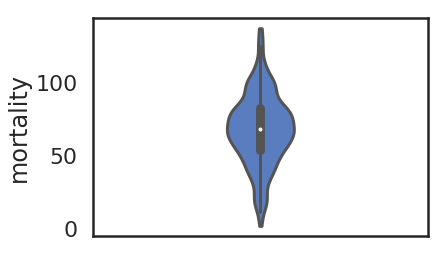

In [112]:
sns.violinplot(dfs_mortality['MG-WT']['mortality'],
               scale='area',cut=0,bw=0.2,gridsize=100,palette="muted",orient='v',
               width=0.2, inner='box')

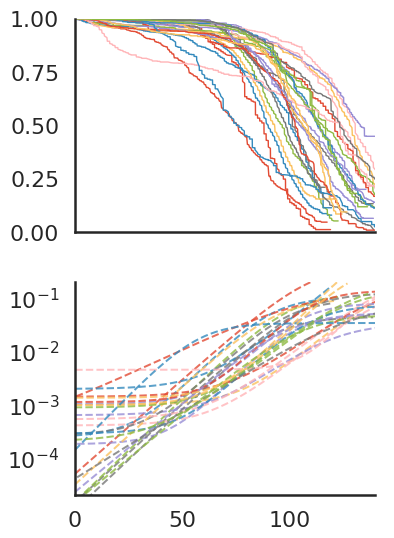

In [113]:
from cohortMortalitySummary import KaplanMeier, NelsonAalen, Breslow, BSHazardR, generate_ts_image
f, (ax1, ax3) = plt.subplots(2, 1, sharex=True, sharey=False)
for strain in list(set.intersection(set(initial_strains), shape_diff, rate_non)):
    KM = KaplanMeier(dfs_mortality[strain], tgs_mortality[strain])
    ax1.plot(KM.index,KM.loc[:,'survivorship'],linewidth=1.4)
    #ax1.plot(tgs_mortality[strain][1:],Fitted[strain]['ML_survivorship'](tgs_mortality[strain][1:]),linewidth=2, linestyle='--',alpha=0.8)
    #ax1.fill_between(KM.index,KM.loc[:,'lower_ci'],KM.loc[:,'upper_ci'],
    #                        alpha=0.3)
    #BSFit = BSFits[strain]
    #ax3.plot(BSFit['time'],BSFit['hazard'],linewidth=1.4)
    #ax3.fill_between(BSFit['time'],BSFit['lower.ci'],BSFit['upper.ci'],
    #                        alpha=0.5)
    ax3.plot(tgs_mortality[strain][1:],Fitted[strain]['ML_hazard'](tgs_mortality[strain][1:]),linewidth=2, linestyle='--',alpha=0.8)
ax1.set_ylim([0,1])
ax1.set_xlim([0,140])
ax3.set_yscale('log')
ax3.set_ylim([0.00002,0.2])
sns.despine()
f.set_size_inches(6,8)
plt.tight_layout()

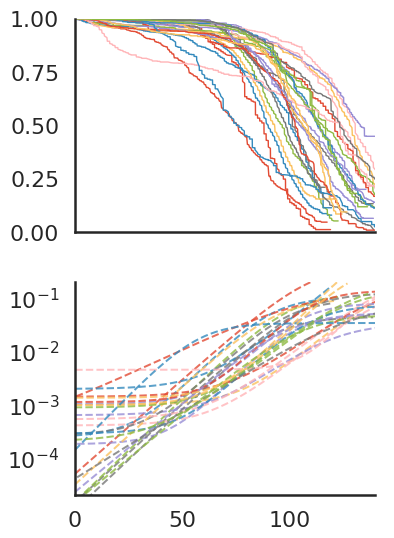

In [114]:
from cohortMortalitySummary import KaplanMeier, NelsonAalen, Breslow, BSHazardR, generate_ts_image
f, (ax1, ax3) = plt.subplots(2, 1, sharex=True, sharey=False)
for strain in list(set.intersection(set(initial_strains), shape_diff, rate_non)):
    KM = KaplanMeier(dfs_mortality[strain], tgs_mortality[strain])
    ax1.plot(KM.index,KM.loc[:,'survivorship'],linewidth=1.4)
    #ax1.plot(tgs_mortality[strain][1:],Fitted[strain]['ML_survivorship'](tgs_mortality[strain][1:]),linewidth=2, linestyle='--',alpha=0.8)
    #ax1.fill_between(KM.index,KM.loc[:,'lower_ci'],KM.loc[:,'upper_ci'],
    #                        alpha=0.3)
    #BSFit = BSHazardR(dfs_mortality[strain])
    #ax3.plot(BSFit['time'],BSFit['hazard'],linewidth=1.4)
    #ax3.fill_between(BSFit['time'],BSFit['lower.ci'],BSFit['upper.ci'],
    #                        alpha=0.5)
    ax3.plot(tgs_mortality[strain][1:],Fitted[strain]['ML_hazard'](tgs_mortality[strain][1:]),linewidth=2, linestyle='--',alpha=0.8)
ax1.set_ylim([0,1])
ax1.set_xlim([0,140])
ax3.set_yscale('log')
ax3.set_ylim([0.00002,0.2])
sns.despine()
f.set_size_inches(6,8)
plt.tight_layout()

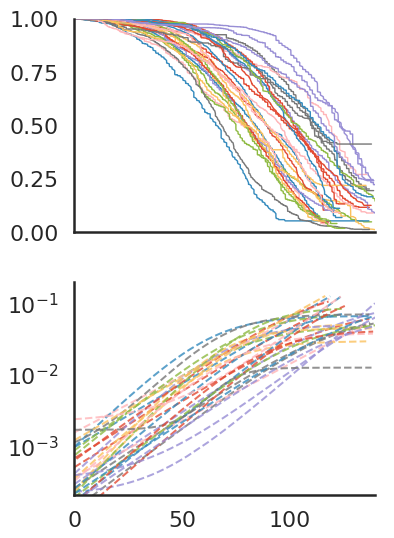

In [115]:
from cohortMortalitySummary import KaplanMeier, NelsonAalen, Breslow, BSHazardR, generate_ts_image
f, (ax1, ax3) = plt.subplots(2, 1, sharex=True, sharey=False)
for strain in list(set.intersection(set(initial_strains), shape_non)):
    KM = KaplanMeier(dfs_mortality[strain], tgs_mortality[strain])
    ax1.plot(KM.index,KM.loc[:,'survivorship'],linewidth=1.4)
    #ax1.plot(tgs_mortality[strain][1:],Fitted[strain]['ML_survivorship'](tgs_mortality[strain][1:]),linewidth=2, linestyle='--',alpha=0.8)
    #ax1.fill_between(KM.index,KM.loc[:,'lower_ci'],KM.loc[:,'upper_ci'],
    #                        alpha=0.3)
    #BSFit = BSFits[strain]
    #ax3.plot(BSFit['time'],BSFit['hazard'],linewidth=1.4)
    #ax3.fill_between(BSFit['time'],BSFit['lower.ci'],BSFit['upper.ci'],
    #                        alpha=0.5)
    ax3.plot(tgs_mortality[strain][1:],Fitted[strain]['ML_hazard'](tgs_mortality[strain][1:]),linewidth=2, linestyle='--',alpha=0.8)
ax1.set_ylim([0,1])
ax1.set_xlim([0,140])
ax3.set_yscale('log')
ax3.set_ylim([0.0002,0.2])
sns.despine()
f.set_size_inches(6,8)
plt.tight_layout()

# 8. Correlations between aging and growth parameters

### 8.1 Growth yields vs aging parameters

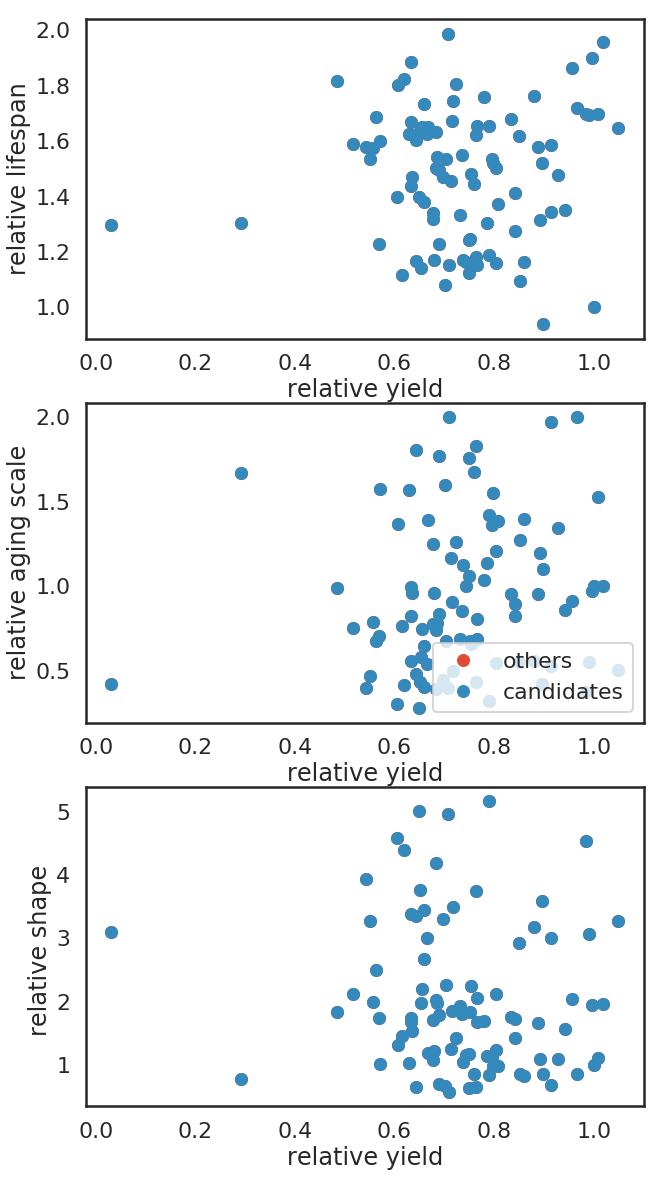

In [116]:
strain_df['yield_ratio_log2'] = [np.log2(float(r)/strain_df.loc['MG-WT','yield_mean']) for r in strain_df['yield_mean']]
strain_df['yield_ratio'] = [float(r)/strain_df.loc['MG-WT','yield_mean'] for r in strain_df['yield_mean']]

f, (ax3, ax1, ax2) = plt.subplots(3, sharex=False)

ax1.plot(strain_df.loc[initial_strains, 'yield_ratio'], 
         strain_df.loc[initial_strains, 'scale_ratio'],
         'o',label='others')
ax1.plot(strain_df.loc[candidates, 'yield_ratio'],
         strain_df.loc[candidates, 'scale_ratio'], 'o', label='candidates')
ax1.set_ylabel('relative aging scale')
ax1.set_xlabel('relative yield')
#ax1.plot(np.arange(4,-4,-0.1), [0]*80, '--')
#ax1.plot(np.arange(2,-3,-0.1), np.arange(2,-3,-0.1), '--', label='equal shape')
ax1.legend(loc=4)


ax2.plot(strain_df.loc[initial_strains, 'yield_ratio'], 
         np.power(2,strain_df.loc[initial_strains, 'shape_ratio_log2']),
         'o',label='others')
ax2.plot(strain_df.loc[candidates, 'yield_ratio'],
         np.power(2,strain_df.loc[candidates, 'shape_ratio_log2']), 'o', label='candidates')
ax2.set_xlabel('relative yield')
ax2.set_ylabel('relative shape ')
#ax2.plot(np.arange(3,-4,-0.1), np.arange(-3,4,0.1), '--', label='equal lifespan')
#ax2.plot(np.arange(4,-4,-0.1), [0]*80, '--')
#ax2.legend(loc=1)

#ax1.set_xlim([-1.5,1.5])
#ax2.set_xlim([-1.5,1.5])
#ax1.set_ylim([-1.6,0.9])
#ax2.set_ylim([-1,1.5])

ax3.plot(strain_df.loc[initial_strains, 'yield_ratio'], 
         strain_df.loc[initial_strains, 'med_ratio'],
         'o',label='others')
ax3.plot(strain_df.loc[candidates, 'yield_ratio'],
         strain_df.loc[candidates, 'med_ratio'], 'o', label='candidates')
ax3.set_ylabel('relative lifespan')
ax3.set_xlabel('relative yield')
#ax1.plot(np.arange(4,-4,-0.1), [0]*80, '--')
#ax1.plot(np.arange(2,-3,-0.1), np.arange(2,-3,-0.1), '--', label='equal shape')
#ax3.legend(loc=4)

f.set_size_inches(10,20)

In [117]:
growth_curve_raw_df = pandas.read_csv('/Users/yyfwuhan/Projects/2018-TaMaRa-Ana-figures/growth/Growth Curves Raw Data MS1.csv',sep=';')
max_od = growth_curve_raw_df.iloc[0,1:]
for gene in max_od.index:
    value = float(max_od.loc[gene].replace(',','.'))
    if '.' not in gene:
        yield_df.loc[gene, 'R1'] = value - 0.044
    else:
        yield_df.loc[gene.split('.')[0], 'R'+str(int(gene.split('.')[1])+1)] = value - 0.044

IOError: File /Users/yyfwuhan/Projects/2018-TaMaRa-Ana-figures/growth/Growth Curves Raw Data MS1.csv does not exist

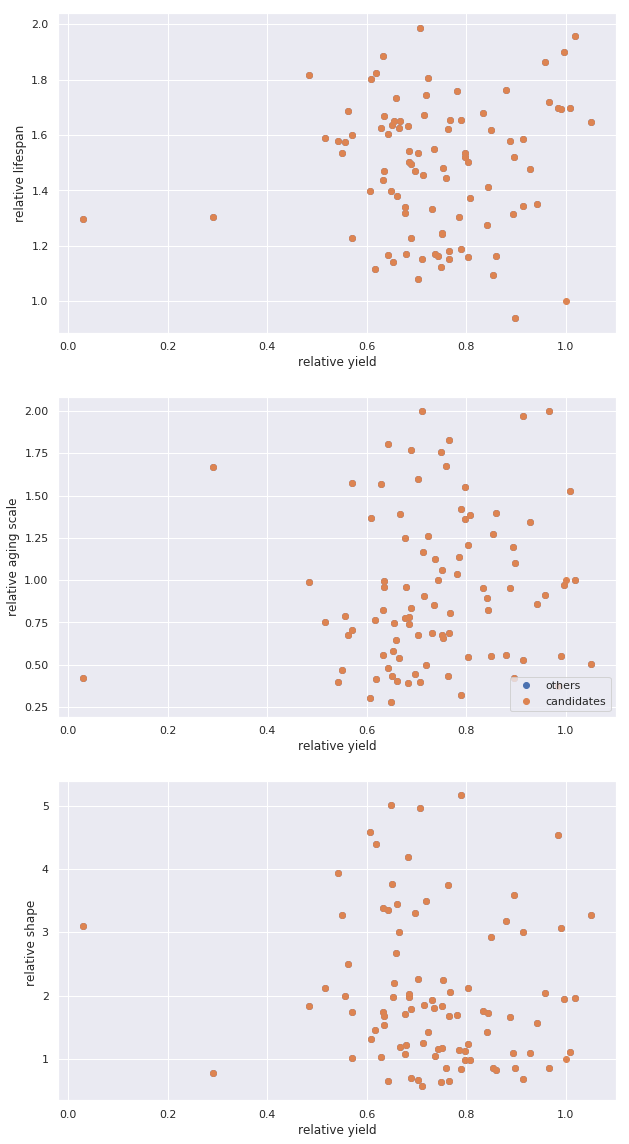

In [125]:
sns.set()
strain_df['yield_ratio_log2'] = [np.log2(float(r)/strain_df.loc['MG-WT','yield_mean']) for r in strain_df['yield_mean']]
strain_df['yield_ratio'] = [float(r)/strain_df.loc['MG-WT','yield_mean'] for r in strain_df['yield_mean']]

f, (ax3, ax1, ax2) = plt.subplots(3, sharex=False)

ax1.plot(strain_df.loc[initial_strains, 'yield_ratio'], 
         strain_df.loc[initial_strains, 'scale_ratio'],
         'o',label='others')
ax1.plot(strain_df.loc[candidates, 'yield_ratio'],
         strain_df.loc[candidates, 'scale_ratio'], 'o', label='candidates')
ax1.set_ylabel('relative aging scale')
ax1.set_xlabel('relative yield')
#ax1.plot(np.arange(4,-4,-0.1), [0]*80, '--')
#ax1.plot(np.arange(2,-3,-0.1), np.arange(2,-3,-0.1), '--', label='equal shape')
ax1.legend(loc=4)


ax2.plot(strain_df.loc[initial_strains, 'yield_ratio'], 
         np.power(2,strain_df.loc[initial_strains, 'shape_ratio_log2']),
         'o',label='others')
ax2.plot(strain_df.loc[candidates, 'yield_ratio'],
         np.power(2,strain_df.loc[candidates, 'shape_ratio_log2']), 'o', label='candidates')
ax2.set_xlabel('relative yield')
ax2.set_ylabel('relative shape ')
#ax2.plot(np.arange(3,-4,-0.1), np.arange(-3,4,0.1), '--', label='equal lifespan')
#ax2.plot(np.arange(4,-4,-0.1), [0]*80, '--')
#ax2.legend(loc=1)

#ax1.set_xlim([-1.5,1.5])
#ax2.set_xlim([-1.5,1.5])
#ax1.set_ylim([-1.6,0.9])
#ax2.set_ylim([-1,1.5])

ax3.plot(strain_df.loc[initial_strains, 'yield_ratio'], 
         strain_df.loc[initial_strains, 'med_ratio'],
         'o',label='others')
ax3.plot(strain_df.loc[candidates, 'yield_ratio'],
         strain_df.loc[candidates, 'med_ratio'], 'o', label='candidates')
ax3.set_ylabel('relative lifespan')
ax3.set_xlabel('relative yield')
#ax1.plot(np.arange(4,-4,-0.1), [0]*80, '--')
#ax1.plot(np.arange(2,-3,-0.1), np.arange(2,-3,-0.1), '--', label='equal shape')
#ax3.legend(loc=4)

f.set_size_inches(10,20)

### 8.2 Growth rates vs aging parameters

In [126]:
#grate_df = pandas.read_csv('/Users/yyfwuhan/Projects/2018-TaMaRa-Ana-figures/growth/Growth Rate of KO - Sheet1.csv',sep=',')
grate_df = pandas.read_csv('growth_rate_all_strains.csv',sep=',')

grate_df.set_index('Unnamed: 0', inplace=True)

initial_genes = list(grate_df.index)
initial_strains = [strain for strain in strain_df.index
                   if strain.split('_')[0] in initial_genes]
other_strains = [strain for strain in strain_df.index
                   if strain.split('_')[0] not in initial_genes]
for strain in initial_strains:
    strain_df.loc[strain, 'growr_mean'] = np.mean(np.mean(grate_df.loc[strain.split('_')[0], :]))
    strain_df.loc[strain, 'growr_std'] = np.mean(np.std(grate_df.loc[strain.split('_')[0], :]))

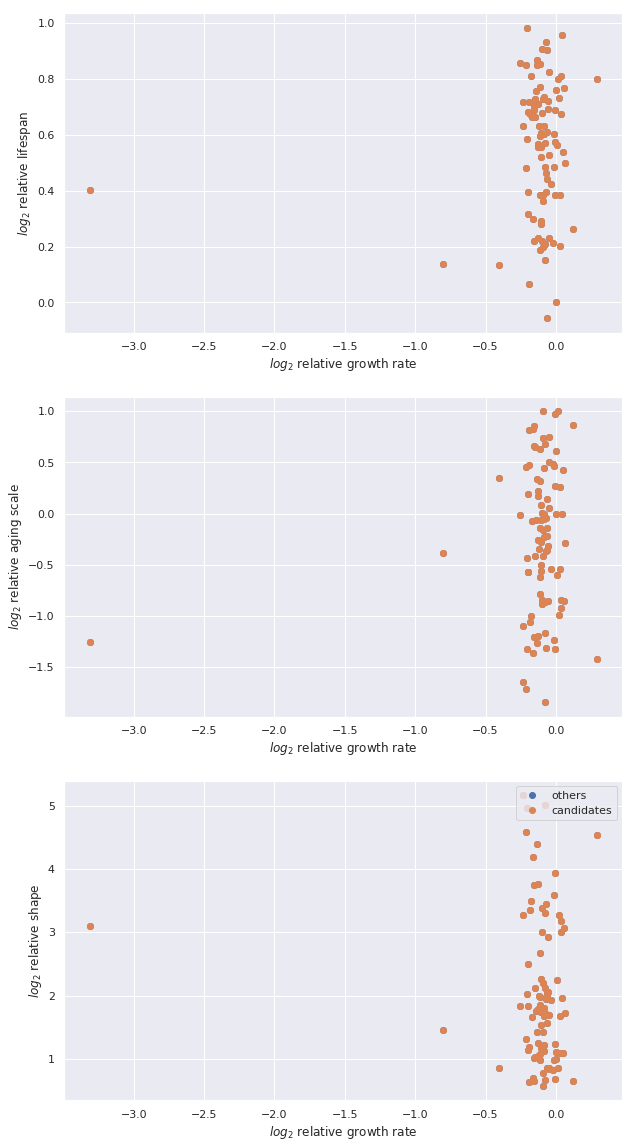

In [127]:
strain_df['growr_ratio_log2'] = [np.log2(float(r)/strain_df.loc['MG-WT','growr_mean']) for r in strain_df['growr_mean']]
strain_df['growr_ratio'] = [float(r)/strain_df.loc['MG-WT','growr_mean'] for r in strain_df['growr_mean']]

f, (ax3, ax1, ax2) = plt.subplots(3, sharex=False)

ax1.plot(strain_df.loc[initial_strains, 'growr_ratio_log2'], 
         strain_df.loc[initial_strains, 'scale_ratio_log2'],
         'o',label='others')
ax1.plot(strain_df.loc[candidates, 'growr_ratio_log2'],
         strain_df.loc[candidates, 'scale_ratio_log2'], 'o', label='candidates')
ax1.set_ylabel('$log_2$ relative aging scale')
ax1.set_xlabel('$log_2$ relative growth rate')
#ax1.plot(np.arange(4,-4,-0.1), [0]*80, '--')
#ax1.plot(np.arange(2,-3,-0.1), np.arange(2,-3,-0.1), '--', label='equal shape')
#ax2.legend(loc=4)


ax2.plot(strain_df.loc[initial_strains, 'growr_ratio_log2'], 
         np.power(2,strain_df.loc[initial_strains, 'shape_ratio_log2']),
         'o',label='others')
ax2.plot(strain_df.loc[candidates, 'growr_ratio_log2'],
         np.power(2,strain_df.loc[candidates, 'shape_ratio_log2']), 'o', label='candidates')
ax2.set_xlabel('$log_2$ relative growth rate')
ax2.set_ylabel('$log_2$ relative shape ')
#ax2.plot(np.arange(3,-4,-0.1), np.arange(-3,4,0.1), '--', label='equal lifespan')
#ax2.plot(np.arange(4,-4,-0.1), [0]*80, '--')
ax2.legend(loc=1)

#ax1.set_xlim([-1.5,1.5])
#ax2.set_xlim([-1.5,1.5])
#ax1.set_ylim([-1.6,0.9])
#ax2.set_ylim([-1,1.5])

ax3.plot(strain_df.loc[initial_strains, 'growr_ratio_log2'], 
         strain_df.loc[initial_strains, 'lifespan_ratio_log2'],
         'o',label='others')
ax3.plot(strain_df.loc[candidates, 'growr_ratio_log2'],
         strain_df.loc[candidates, 'lifespan_ratio_log2'], 'o', label='candidates')
ax3.set_ylabel('$log_2$ relative lifespan')
ax3.set_xlabel('$log_2$ relative growth rate')
#ax1.plot(np.arange(4,-4,-0.1), [0]*80, '--')
#ax1.plot(np.arange(2,-3,-0.1), np.arange(2,-3,-0.1), '--', label='equal shape')
#ax3.legend(loc=4)

f.set_size_inches(10,20)

In [128]:
#grate_df_new = pandas.read_csv('/Users/yyfwuhan/Projects/2018-TaMaRa-Ana-figures/growth/growth_rate_max_xiaohu.csv',sep=',')


grate_df_new = pandas.read_csv('growth_rate_all_strains.csv',sep=',')

grate_dict = dict()
for i in range(len(grate_df_new)):
    name = grate_df_new.iloc[i,0]
    if grate_dict.has_key(name.split('-')[0]):
        grate_dict[name.split('-')[0]].append(grate_df_new.iloc[i,1])
    else:
        grate_dict[name.split('-')[0]] = [grate_df_new.iloc[i,1]]
initial_genes = list()
initial_strains = list()
for gene, grates in grate_dict.items():
    init_mean = np.mean(grates)
    init_std = np.std(grates)
    for gr in grates:
        if np.abs(gr - init_mean) > 2*init_std:
            print gene, gr, init_mean, init_std
            grates.remove(gr)
    if len(grates) != 0:
        try:
            initial_genes.append(gene)
            initial_strains.extend([strain for strain in strain_df.index if strain.split('_')[0] == gene])
            strain = initial_strains[-1]
            strain_df.loc[strain, 'growr_mean'] = np.mean(grates)
            strain_df.loc[strain, 'growr_std'] = np.std(grates)
        except:
            "error", gene, grates
        
other_strains = [strain for strain in strain_df.index
                   if strain.split('_')[0] not in initial_genes]

WT 0.623403927145 0.5233185617259286 0.03165956818577151


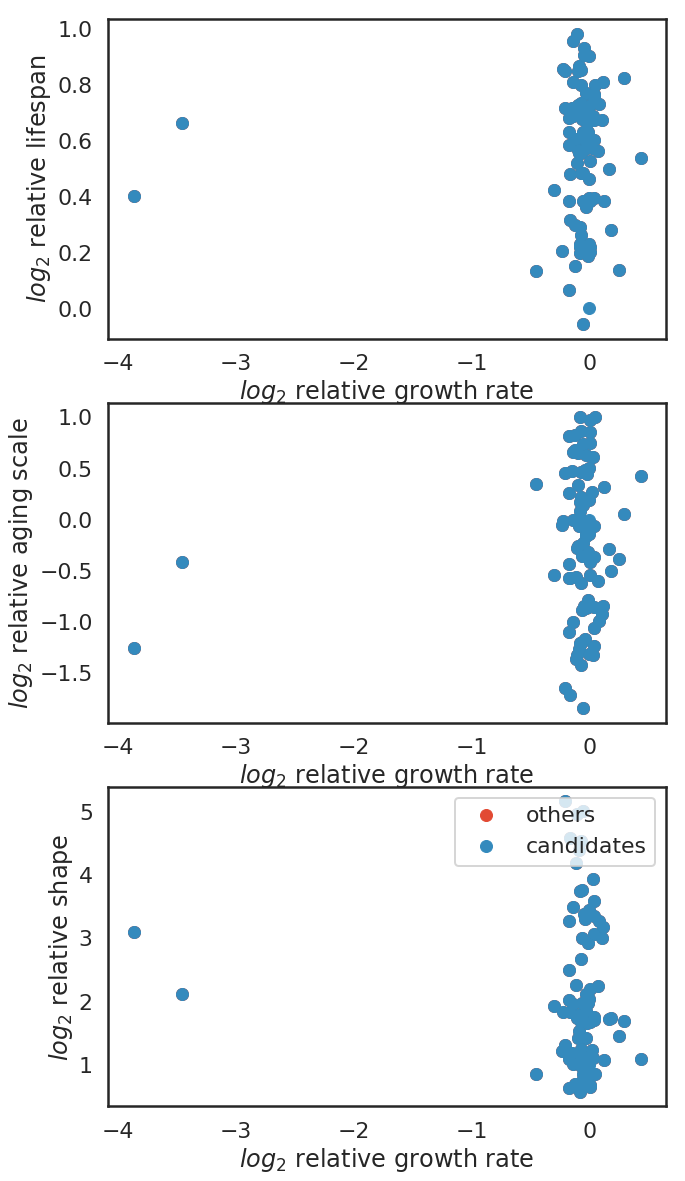

In [122]:
strain_df['growr_ratio_log2'] = [np.log2(float(r)/strain_df.loc['MG-WT','growr_mean']) for r in strain_df['growr_mean']]
strain_df['growr_ratio'] = [float(r)/strain_df.loc['MG-WT','growr_mean'] for r in strain_df['growr_mean']]

f, (ax3, ax1, ax2) = plt.subplots(3, sharex=False)

ax1.plot(strain_df.loc[initial_strains, 'growr_ratio_log2'], 
         strain_df.loc[initial_strains, 'scale_ratio_log2'],
         'o',label='others')
ax1.plot(strain_df.loc[candidates, 'growr_ratio_log2'],
         strain_df.loc[candidates, 'scale_ratio_log2'], 'o', label='candidates')
ax1.set_ylabel('$log_2$ relative aging scale')
ax1.set_xlabel('$log_2$ relative growth rate')
#ax1.plot(np.arange(4,-4,-0.1), [0]*80, '--')
#ax1.plot(np.arange(2,-3,-0.1), np.arange(2,-3,-0.1), '--', label='equal shape')
#ax2.legend(loc=4)


ax2.plot(strain_df.loc[initial_strains, 'growr_ratio_log2'], 
         np.power(2,strain_df.loc[initial_strains, 'shape_ratio_log2']),
         'o',label='others')
ax2.plot(strain_df.loc[candidates, 'growr_ratio_log2'],
         np.power(2,strain_df.loc[candidates, 'shape_ratio_log2']), 'o', label='candidates')
ax2.set_xlabel('$log_2$ relative growth rate')
ax2.set_ylabel('$log_2$ relative shape ')
#ax2.plot(np.arange(3,-4,-0.1), np.arange(-3,4,0.1), '--', label='equal lifespan')
#ax2.plot(np.arange(4,-4,-0.1), [0]*80, '--')
ax2.legend(loc=1)

#ax1.set_xlim([-1.5,1.5])
#ax2.set_xlim([-1.5,1.5])
#ax1.set_ylim([-1.6,0.9])
#ax2.set_ylim([-1,1.5])

ax3.plot(strain_df.loc[initial_strains, 'growr_ratio_log2'], 
         strain_df.loc[initial_strains, 'lifespan_ratio_log2'],
         'o',label='others')
ax3.plot(strain_df.loc[candidates, 'growr_ratio_log2'],
         strain_df.loc[candidates, 'lifespan_ratio_log2'], 'o', label='candidates')
ax3.set_ylabel('$log_2$ relative lifespan')
ax3.set_xlabel('$log_2$ relative growth rate')
#ax1.plot(np.arange(4,-4,-0.1), [0]*80, '--')
#ax1.plot(np.arange(2,-3,-0.1), np.arange(2,-3,-0.1), '--', label='equal shape')
#ax3.legend(loc=4)

f.set_size_inches(10,20)

### 8.3 Strains with extreme growth rates: are growth rate estimates correct?

In [123]:
strain_df.loc[strain_df['growr_ratio_log2']>1,['growr_ratio_log2','scale_ratio_log2','lifespan_ratio_log2','shape_ratio_log2']]

,growr_ratio_log2,scale_ratio_log2,lifespan_ratio_log2,shape_ratio_log2


In [124]:
strain_df.loc[strain_df['growr_ratio_log2']<-0.75,['growr_ratio_log2','scale_ratio_log2','lifespan_ratio_log2','shape_ratio_log2']]

,growr_ratio_log2,scale_ratio_log2,lifespan_ratio_log2,shape_ratio_log2
ygjP,-3.455067,-0.414734,0.664650,1.081690
yihS,-3.867854,-1.256448,0.404245,1.633011
